In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras.saving import register_keras_serializable
# import tensorflow_addons as tfa
import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
%matplotlib inline

seed = 69
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [2]:
## Load data
data = np.load("/kaggle/input/lolllll/cleaned_mars_for_students.npz")
X_train = data['images']
y_train = data['labels']

X_test = data['test_set']
NUM_CLASSES = len(np.unique(y_train))

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

@register_keras_serializable()
class CombinedSegmentationLoss(tf.keras.losses.Loss):
    def __init__(self, 
                 num_classes,
                 class_frequencies=None,
                 alpha=0.25, 
                 gamma=2.0, 
                 focal_weight=1.0, 
                 dice_weight=1.0, 
                 ce_weight=1.0,
                 boundary_weight=1.0,
                 jaccard_weight=1.0,
                 ignore_class=0):
        """
        Combined loss function for semantic segmentation with class balancing.
        
        Args:
            num_classes: Total number of classes including background
            class_frequencies: Array of class frequencies (if None, will be computed during training)
            alpha: Focal loss focusing parameter
            gamma: Focal loss modulating factor
            focal_weight: Weight for focal loss
            dice_weight: Weight for dice loss
            ce_weight: Weight for categorical crossentropy
            boundary_weight: Weight for boundary loss
            ignore_class: Class index to ignore in loss calculation (usually background)
        """
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.boundary_weight = boundary_weight
        self.jaccard_weight = jaccard_weight
        self.ignore_class = ignore_class
        
        # Initialize class weights if frequencies are provided
        if class_frequencies is not None:
            self.class_weights = self._compute_class_weights(class_frequencies)
        else:
            self.class_weights = None

    def _compute_class_weights(self, class_frequencies):
        """Compute inverse frequency weights for class balancing."""
        eps = 1e-7  # Small epsilon to avoid division by zero
        frequencies = np.array(class_frequencies)
        frequencies[frequencies == 0] = eps
        
        # Inverse frequency weighting
        weights = 1 / (frequencies + eps)
        
        # Normalize weights
        weights = weights / np.sum(weights)

        print("Weigths: ")
        print(tf.constant(weights, dtype=tf.float32))
        
        # Convert to tensor
        return tf.constant(weights, dtype=tf.float32)

    def update_class_weights(self, y_true):
        """Update class weights based on batch statistics."""
        if self.class_weights is None:
            # Calculate class frequencies from current batch
            batch_frequencies = tf.reduce_sum(
                tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes),
                axis=[0, 1, 2]
            )
            self.class_weights = self._compute_class_weights(batch_frequencies)

    def dice_loss(self, y_true, y_pred):
        """Calculate class-weighted Dice loss."""
        # Create mask for non-ignored classes
        mask = tf.cast(y_true != self.ignore_class, tf.float32)
        
        # Convert sparse to one-hot
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Apply class weights
        weighted_pred = y_pred * self.class_weights[tf.newaxis, tf.newaxis, tf.newaxis, :]
        
        # Calculate Dice coefficient with class weights
        intersection = tf.reduce_sum(y_true_one_hot * weighted_pred * mask[..., tf.newaxis], axis=[0, 1, 2])
        union = tf.reduce_sum(y_true_one_hot * mask[..., tf.newaxis], axis=[0, 1, 2]) + \
                tf.reduce_sum(weighted_pred * mask[..., tf.newaxis], axis=[0, 1, 2])
        
        dice = (2.0 * intersection + K.epsilon()) / (union + K.epsilon())
        return 1.0 - tf.reduce_mean(dice)

    def focal_loss(self, y_true, y_pred):
        """Calculate class-weighted Focal loss."""
        mask = tf.cast(y_true != self.ignore_class, tf.float32)
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Apply class weights to predictions
        weighted_pred = y_pred * self.class_weights[tf.newaxis, tf.newaxis, tf.newaxis, :]
        
        # Calculate focal loss with class weights
        ce = -y_true_one_hot * tf.math.log(weighted_pred + K.epsilon())
        weight = tf.pow(1.0 - weighted_pred, self.gamma)
        fl = self.alpha * weight * ce
        
        fl = fl * mask[..., tf.newaxis]
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))

    def boundary_loss(self, y_true, y_pred):
        """Calculate boundary-aware loss using image gradients."""
        # Convert sparse to one-hot
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Calculate gradients
        dy_true, dx_true = tf.image.image_gradients(tf.cast(y_true_one_hot, tf.float32))
        dy_pred, dx_pred = tf.image.image_gradients(y_pred)
        
        # Calculate boundary loss
        boundary_loss = tf.reduce_mean(
            tf.abs(dy_pred - dy_true) + tf.abs(dx_pred - dx_true),
            axis=[1, 2, 3]
        )
        
        return tf.reduce_mean(boundary_loss)

    def categorical_crossentropy(self, y_true, y_pred):
        """Calculate class-weighted categorical crossentropy."""
        mask = tf.cast(y_true != self.ignore_class, tf.float32)
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Apply class weights to predictions
        weighted_pred = y_pred * self.class_weights[tf.newaxis, tf.newaxis, tf.newaxis, :]
        
        ce = -y_true_one_hot * tf.math.log(weighted_pred + K.epsilon())
        ce = ce * mask[..., tf.newaxis]
        return tf.reduce_mean(tf.reduce_sum(ce, axis=-1))


    def call(self, y_true, y_pred):
        """Combine all losses with their respective weights."""
        # Update class weights if necessary
        self.update_class_weights(y_true)
        
        # Calculate individual losses
        fl = self.focal_loss(y_true, y_pred) * self.focal_weight
        dl = self.dice_loss(y_true, y_pred) * self.dice_weight
        ce = self.categorical_crossentropy(y_true, y_pred) * self.ce_weight
        bl = self.boundary_loss(y_true, y_pred) * self.boundary_weight
        j1 = JaccardLoss(num_classes=NUM_CLASSES,labels_to_exclude=[0])(y_true, y_pred) * self.jaccard_weight
        
        return fl + dl + ce + bl + j1

In [4]:
import tensorflow as tf

class JaccardLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, labels_to_exclude=None, name="jaccard_loss", reduction="sum_over_batch_size"):
        """
        Jaccard Loss (1 - Intersection over Union) for multi-class segmentation.
        
        Args:
            num_classes (int): Total number of classes in the segmentation problem
            labels_to_exclude (list, optional): Labels to exclude from IoU calculation. 
                                                Defaults to [0] if not specified.
            name (str, optional): Name of the loss. Defaults to "jaccard_loss".
            reduction (str, optional): Type of reduction to apply. 
                                       Defaults to "sum_over_batch_size".
        """
        super().__init__(name=name, reduction=reduction)
        self.num_classes = num_classes
        self.labels_to_exclude = labels_to_exclude or [0]
    
    def call(self, y_true, y_pred):
        """
        Calculate Jaccard Loss
        
        Args:
            y_true (tf.Tensor): True labels, shape (batch_size, height, width) for segmentation
            y_pred (tf.Tensor): Predicted probabilities, shape (batch_size, height, width, num_classes)
        
        Returns:
            tf.Tensor: Jaccard Loss value
        """
        # Convert true labels to one-hot encoding
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)
        
        # Compute intersection and union for each class
        intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=[0, 1, 2])
        true_sum = tf.reduce_sum(y_true_one_hot, axis=[0, 1, 2])
        pred_sum = tf.reduce_sum(y_pred, axis=[0, 1, 2])
        
        # Compute IoU for each class
        union = true_sum + pred_sum - intersection
        
        # Compute IoU, avoiding division by zero
        iou = tf.where(
            union > 0, 
            intersection / union, 
            tf.ones_like(intersection)
        )
        
        # Remove excluded labels
        for label in self.labels_to_exclude:
            iou = tf.concat([
                iou[:label], 
                iou[label+1:]
            ], axis=0)
        
        # Compute mean IoU and Jaccard Loss
        mean_iou = tf.reduce_mean(iou)
        jaccard_loss = 1.0 - mean_iou
        
        return jaccard_loss

class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [5]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl

def squeeze_excitation_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    # Squeeze
    x = tfkl.GlobalAveragePooling2D()(input_tensor)
    # Excitation
    x = tfkl.Dense(channels // reduction_ratio, activation='relu')(x)
    x = tfkl.Dense(channels, activation='sigmoid')(x)
    # Reshape and multiply
    x = tfkl.Reshape((1, 1, channels))(x)
    return tfkl.multiply([input_tensor, x])

def global_context_module(input_tensor):
    channels = input_tensor.shape[-1]
    # Global context
    context = tfkl.GlobalAveragePooling2D()(input_tensor)
    context = tfkl.Dense(channels // 2, activation='relu')(context)
    context = tfkl.Dense(channels, activation='sigmoid')(context)
    context = tfkl.Reshape((1, 1, channels))(context)
    # Broadcast and multiply
    return tfkl.multiply([input_tensor, context])

def parallel_dilated_conv_block(input_tensor, filters):
    # Three parallel branches with different dilation rates
    d1 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=1)(input_tensor)
    d2 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=2)(input_tensor)
    d4 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=4)(input_tensor)
    d8 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=8)(input_tensor)
    
    # Concatenate all branches
    return tfkl.Concatenate()([d1, d2, d4, d8])

def enhanced_unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
    return x

def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    # Learning rate schedule
    initial_learning_rate = 0.001  # assuming this is LEARNING_RATE
    decay_steps = 1000
    decay_rate = 0.9
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps, decay_rate
    )
    
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    # Downsampling path
    down_block_1 = enhanced_unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)
    d1 = tfkl.Dropout(0.3)(d1)
    
    down_block_2 = enhanced_unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)
    d2 = tfkl.Dropout(0.3)(d2)
    
    down_block_3 = enhanced_unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)
    d3 = tfkl.Dropout(0.3)(d3)
    
    down_block_4 = enhanced_unet_block(d3, 256, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)
    d4 = tfkl.Dropout(0.4)(d4)
    
    # Enhanced Bottleneck with all three features
    # 1. Parallel Dilated Convolutions
    bottleneck = parallel_dilated_conv_block(d4, 512)
    bottleneck = tfkl.BatchNormalization()(bottleneck)
    bottleneck = tfkl.Activation('relu')(bottleneck)
    
    # 2. Standard Convolutions
    bottleneck = enhanced_unet_block(bottleneck, 512, name='bottleneck_')
    
    # 3. Global Context Module
    bottleneck = global_context_module(bottleneck)
    
    # 4. Squeeze and Excitation
    bottleneck = squeeze_excitation_block(bottleneck)
    
    bottleneck = tfkl.Dropout(0.5)(bottleneck)
    
    # Upsampling path (keeping same filter counts as original)
    u1 = tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_4])
    u1 = enhanced_unet_block(u1, 256, name='up_block1_')
    
    u2 = tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = enhanced_unet_block(u2, 128, name='up_block2_')
    
    u3 = tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = enhanced_unet_block(u3, 64, name='up_block3_')
    
    u4 = tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = enhanced_unet_block(u4, 32, name='up_block4_')
    
    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='EnhancedUNet')
    return model



In [6]:
def compute_class_frequencies(y_train):
    """
    Compute pixel-wise class frequencies for semantic segmentation data.
    Safely handles both integer and float labels.
    
    Args:
        y_train: Training masks of shape (N, H, W) or (N, H, W, 1)
                Can contain either integer or float labels
    
    Returns:
        class_frequencies: Array of normalized class frequencies
    """
    # Handle 4D masks (N, H, W, 1)
    if len(y_train.shape) == 4 and y_train.shape[-1] == 1:
        y_train = np.squeeze(y_train, axis=-1)
    
    # Convert to integer labels safely
    y_train_int = np.round(y_train).astype(np.int64)
    
    # Get total number of pixels
    total_pixels = y_train_int.size
    
    # Count occurrences of each class
    class_counts = np.bincount(y_train_int.flatten())
    
    # Convert counts to frequencies
    class_frequencies = class_counts / total_pixels
    
    # Print statistics
    print(f"\nClass Distribution Statistics:")
    print(f"Total pixels analyzed: {total_pixels}")
    print(f"Number of unique classes found: {len(class_counts)}")
    print("\nPer-class breakdown:")
    for class_idx, (count, freq) in enumerate(zip(class_counts, class_frequencies)):
        percentage = freq * 100
        print(f"Class {class_idx:2d}: {count:8d} pixels ({percentage:6.2f}%)")
    
    return class_frequencies

In [7]:
frequencies = compute_class_frequencies(y_train)
print(frequencies)


Class Distribution Statistics:
Total pixels analyzed: 20520960
Number of unique classes found: 5

Per-class breakdown:
Class  0:  4988826 pixels ( 24.31%)
Class  1:  6957538 pixels ( 33.90%)
Class  2:  4776810 pixels ( 23.28%)
Class  3:  3770823 pixels ( 18.38%)
Class  4:    26963 pixels (  0.13%)
[0.2431088  0.33904544 0.23277712 0.18375471 0.00131392]


In [8]:
BATCH_SIZE = 256

LEARNING_RATE = .0001

PATIENCE = 35

EPOCHS = 1000

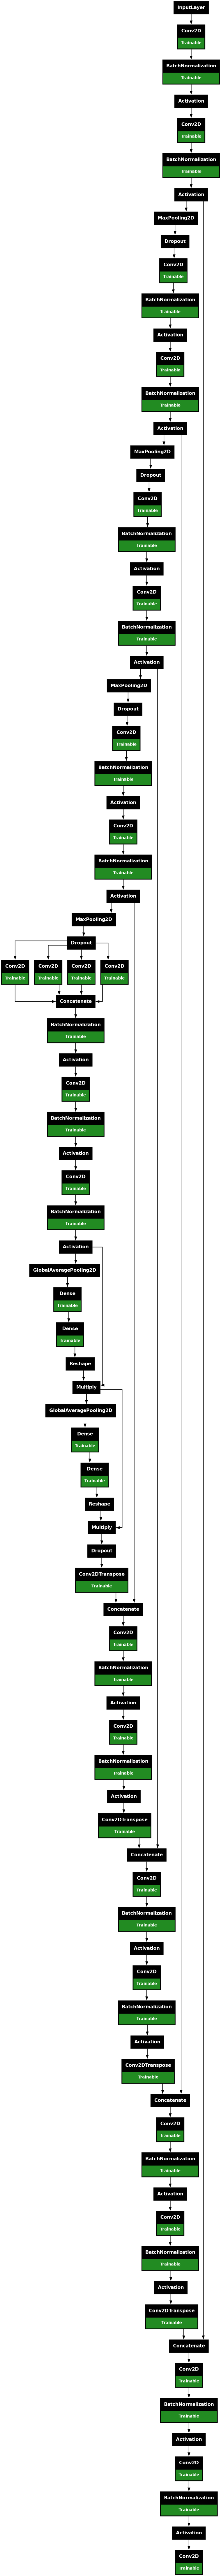

In [9]:
model = get_unet_model()


# Print a detailed summary of the model with expanded nested layers and trainable parameters.
# model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [10]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """

    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)  # Ensure 3 channels
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def random_rotate_images_and_labels(images, labels):
    """
    Function to perform random arbitrary rotation on images and their corresponding labels.
    
    Parameters:
    images (numpy array): Array of grayscale images.
    labels (numpy array): Array of labels corresponding to the images.
    
    Returns:
    rotated_images (numpy array): Array of rotated images.
    rotated_labels (numpy array): Array of rotated labels.
    """
    
    # Create an ImageDataGenerator for random rotation
    datagen = ImageDataGenerator(rotation_range=30)
    
    # Apply the random rotation to each image and its corresponding label
    rotated_images = []
    rotated_labels = []
    
    for img, lbl in zip(images, labels):
        # Expand dimensions to match the expected input shape for ImageDataGenerator
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        lbl = np.expand_dims(lbl, axis=-1)  # Add channel dimension
        
        # Perform random rotation
        img_rotated = datagen.flow(img[np.newaxis, ...], batch_size=1)[0]
        lbl_rotated = datagen.flow(lbl[np.newaxis, ...], batch_size=1)[0]
        
        # Squeeze the dimensions back to original shape
        rotated_images.append(np.squeeze(img_rotated))
        rotated_labels.append(np.squeeze(lbl_rotated))
    
    return np.array(rotated_images), np.array(rotated_labels)

def add_mars_terrain_simulation(image, labels):
    """
    Simulate Mars terrain characteristics:
    - Add Gaussian noise
    - Apply random brightness variations
    - Overlay sinusoidal or fractal-like patterns
    """
    # Add Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=10)
    image = tf.clip_by_value(image + noise, 0.0, 255.0)
    return image, labels

In [12]:
@tf.function
def random_flip_and_solarize(image, label, 
                             flip_lr_seed=None, flip_ud_seed=None, 
                             solarize_seed=None, brightness_seed=None,
                             saturation_seed=None, 
                             threshold=128.0, solarize_prob=0.2, 
                             saturation_factor=(0.5, 1.5),
                             brightness_delta=0.1):
    """Applies random flips (horizontal and vertical), solarization, saturation, and brightness adjustment."""
    
    if flip_lr_seed is None:
        flip_lr_seed = np.random.randint(0, 1000000)
    if flip_ud_seed is None:
        flip_ud_seed = np.random.randint(0, 1000000)
    if solarize_seed is None:
        solarize_seed = np.random.randint(0, 1000000)
    if brightness_seed is None:
        brightness_seed = np.random.randint(0, 1000000)
    if saturation_seed is None:
        saturation_seed = np.random.randint(0, 1000000)
    
    image = tf.expand_dims(tf.expand_dims(image, 0), -1)
    label = tf.expand_dims(tf.expand_dims(label, 0), -1)
    
    # Left-right flip
    flip_lr_prob = tf.random.uniform([], seed=flip_lr_seed)
    image = tf.cond(flip_lr_prob > 0.5,
                    lambda: tf.image.flip_left_right(image),
                    lambda: image)
    label = tf.cond(flip_lr_prob > 0.5,
                    lambda: tf.image.flip_left_right(label),
                    lambda: label)
    
    # Up-down flip
    flip_ud_prob = tf.random.uniform([], seed=flip_ud_seed)
    image = tf.cond(flip_ud_prob > 0.5,
                    lambda: tf.image.flip_up_down(image),
                    lambda: image)
    label = tf.cond(flip_ud_prob > 0.5,
                    lambda: tf.image.flip_up_down(label),
                    lambda: label)
    
    # Solarization
    def solarize(img):
        return tf.where(img > threshold, 255.0 - img, img)
    
    solarize_rand = tf.random.uniform([], seed=solarize_seed)
    image = tf.cond(solarize_rand < solarize_prob,
                    lambda: solarize(image),
                    lambda: image)
    
    # # Random Brightness --> not so useful
    # brightness_rand = tf.random.uniform([], minval=-brightness_delta, 
    #                                      maxval=brightness_delta, 
    #                                      seed=brightness_seed)
    # image = tf.image.adjust_brightness(image, brightness_rand)
    
    image = tf.squeeze(image)
    label = tf.squeeze(label)
    
    return image, label


In [13]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, solarize_seed=None):

    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths

    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    # dataset = dataset.map(
    #     load_single_image,
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, int(y)),
        num_parallel_calls=tf.data.AUTOTUNE

    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip_and_solarize(x, y, solarize_seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=300, random_state=seed
)

In [15]:
X_val.shape

(300, 64, 128)

In [16]:
# Create the datasets

print("Creating datasets...")

train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    solarize_seed=seed
)

X2_train, y2_train = add_mars_terrain_simulation(X_train, y_train)

train_dataset = make_dataset(
    #np.concatenate((X2_train, X_train), axis=0),
    #np.concatenate((y2_train, y_train), axis=0),
    X_train, 
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    solarize_seed=seed+1
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# test_dataset = make_dataset(
#     test_img, test_lbl,
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128)
Images shape: (256, 64, 128)
Labels shape: (256, 64, 128)
Labels dtype: <dtype: 'int32'>


In [17]:
def create_segmentation_colormap(num_classes):

    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]
    return colored

In [18]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency


    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image_path, self.label_path
            label = label
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [19]:
LEARNING_RATE = .001

# Compile the model
print("Compiling model...")

# Compute frequencies from your training data
class_frequencies = compute_class_frequencies(y_train)

# Initialize loss with computed frequencies
combined_loss = CombinedSegmentationLoss(
    num_classes=NUM_CLASSES,
    class_frequencies=class_frequencies,
    alpha=0.25,
    gamma=2.0,
    focal_weight=0,
    dice_weight=0.5,
    ce_weight=1,
    boundary_weight=0.5,
    jaccard_weight=0,
    ignore_class=0
)

model.compile(
    loss=combined_loss,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

print("Model compiled!")

Compiling model...

Class Distribution Statistics:
Total pixels analyzed: 18063360
Number of unique classes found: 5

Per-class breakdown:
Class  0:  4329340 pixels ( 23.97%)
Class  1:  6148209 pixels ( 34.04%)
Class  2:  4263877 pixels ( 23.61%)
Class  3:  3302623 pixels ( 18.28%)
Class  4:    19311 pixels (  0.11%)
Weigths: 
tf.Tensor([0.00438212 0.00308573 0.0044494  0.00574443 0.9823383 ], shape=(5,), dtype=float32)
Model compiled!


In [20]:
# Setup callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_train[135], y_train[135])

Epoch 1/1000


I0000 00:00:1734017962.631223      66 service.cc:145] XLA service 0x78d840004190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734017962.631301      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-12 15:39:57.410607: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,96,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,96,32,64]{3,2,1,0}, f32[256,64,32,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-12 15:39:57.517796: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.107328687s
Trying algorithm eng0{} for conv (

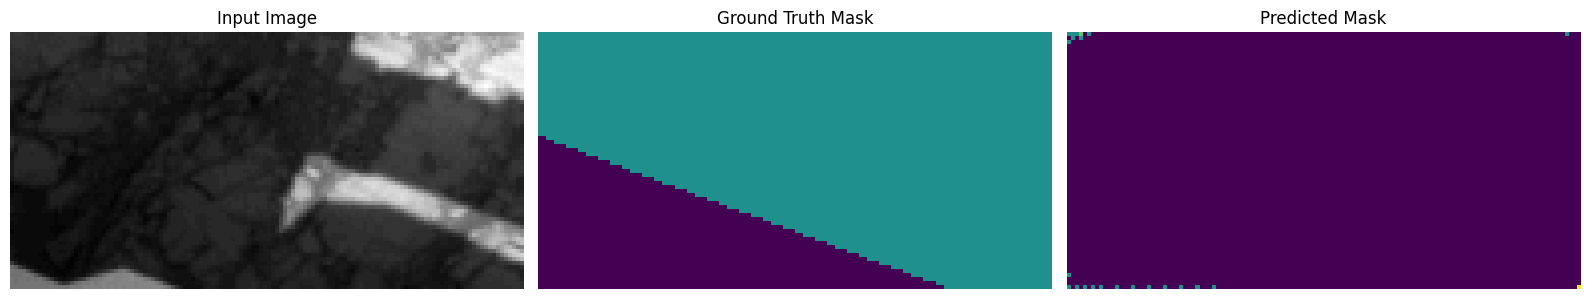

9/9 - 106s - 12s/step - accuracy: 0.2870 - loss: 5.9970 - mean_iou: 0.1335 - val_accuracy: 0.2394 - val_loss: 12.7072 - val_mean_iou: 1.9317e-04
Epoch 2/1000
9/9 - 3s - 381ms/step - accuracy: 0.3808 - loss: 5.6909 - mean_iou: 0.1988 - val_accuracy: 0.2396 - val_loss: 12.7584 - val_mean_iou: 1.6868e-05
Epoch 3/1000
9/9 - 3s - 385ms/step - accuracy: 0.4350 - loss: 5.5471 - mean_iou: 0.2445 - val_accuracy: 0.2379 - val_loss: 12.7302 - val_mean_iou: 0.0020
Epoch 4/1000
9/9 - 3s - 383ms/step - accuracy: 0.4899 - loss: 5.4518 - mean_iou: 0.2882 - val_accuracy: 0.2378 - val_loss: 12.7178 - val_mean_iou: 0.0022
Epoch 5/1000
9/9 - 3s - 378ms/step - accuracy: 0.5188 - loss: 5.3858 - mean_iou: 0.3108 - val_accuracy: 0.2385 - val_loss: 12.7337 - val_mean_iou: 0.0015
Epoch 6/1000


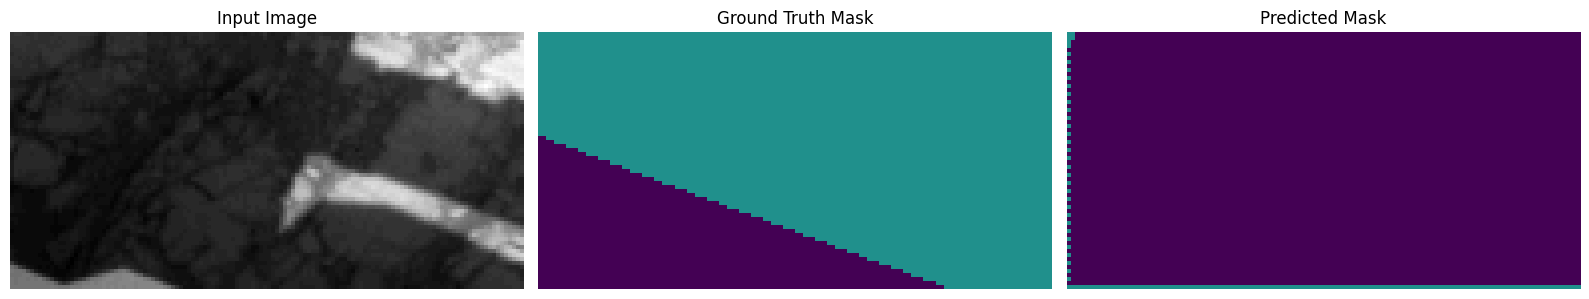

9/9 - 4s - 415ms/step - accuracy: 0.5494 - loss: 5.3176 - mean_iou: 0.3372 - val_accuracy: 0.2368 - val_loss: 12.7197 - val_mean_iou: 0.0032
Epoch 7/1000
9/9 - 3s - 379ms/step - accuracy: 0.5624 - loss: 5.2813 - mean_iou: 0.3506 - val_accuracy: 0.2377 - val_loss: 12.7362 - val_mean_iou: 0.0020
Epoch 8/1000
9/9 - 3s - 383ms/step - accuracy: 0.5695 - loss: 5.2452 - mean_iou: 0.3568 - val_accuracy: 0.2375 - val_loss: 12.6135 - val_mean_iou: 0.0038
Epoch 9/1000
9/9 - 3s - 378ms/step - accuracy: 0.5881 - loss: 5.2059 - mean_iou: 0.3745 - val_accuracy: 0.2384 - val_loss: 12.6704 - val_mean_iou: 0.0026
Epoch 10/1000
9/9 - 3s - 383ms/step - accuracy: 0.5752 - loss: 5.2213 - mean_iou: 0.3621 - val_accuracy: 0.2411 - val_loss: 12.1959 - val_mean_iou: 0.0084
Epoch 11/1000


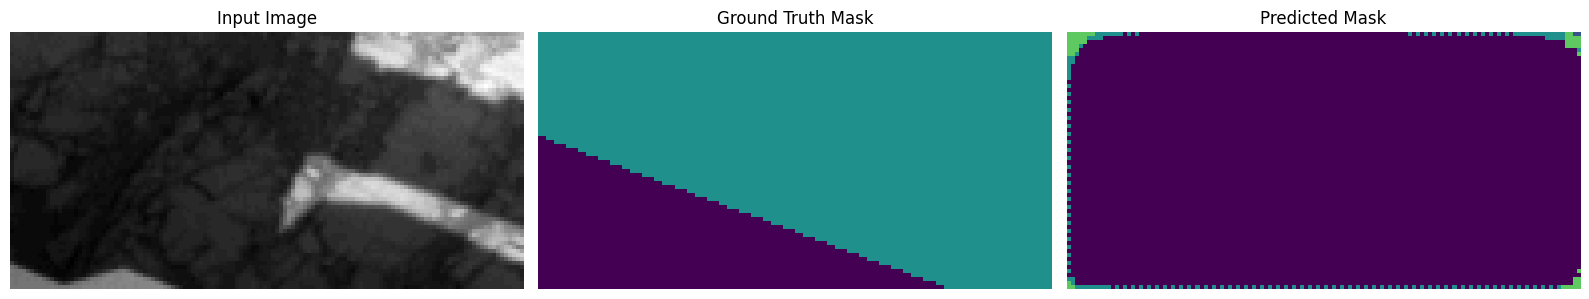

9/9 - 4s - 427ms/step - accuracy: 0.5953 - loss: 5.1745 - mean_iou: 0.3826 - val_accuracy: 0.2636 - val_loss: 10.2872 - val_mean_iou: 0.0440
Epoch 12/1000
9/9 - 3s - 384ms/step - accuracy: 0.5891 - loss: 5.1833 - mean_iou: 0.3762 - val_accuracy: 0.2657 - val_loss: 10.1654 - val_mean_iou: 0.0499
Epoch 13/1000
9/9 - 3s - 384ms/step - accuracy: 0.5989 - loss: 5.1532 - mean_iou: 0.3835 - val_accuracy: 0.3177 - val_loss: 7.7850 - val_mean_iou: 0.1299
Epoch 14/1000
9/9 - 3s - 378ms/step - accuracy: 0.6244 - loss: 5.0972 - mean_iou: 0.4149 - val_accuracy: 0.2770 - val_loss: 8.7076 - val_mean_iou: 0.0848
Epoch 15/1000
9/9 - 3s - 378ms/step - accuracy: 0.6346 - loss: 5.0773 - mean_iou: 0.4247 - val_accuracy: 0.2859 - val_loss: 8.8675 - val_mean_iou: 0.0937
Epoch 16/1000


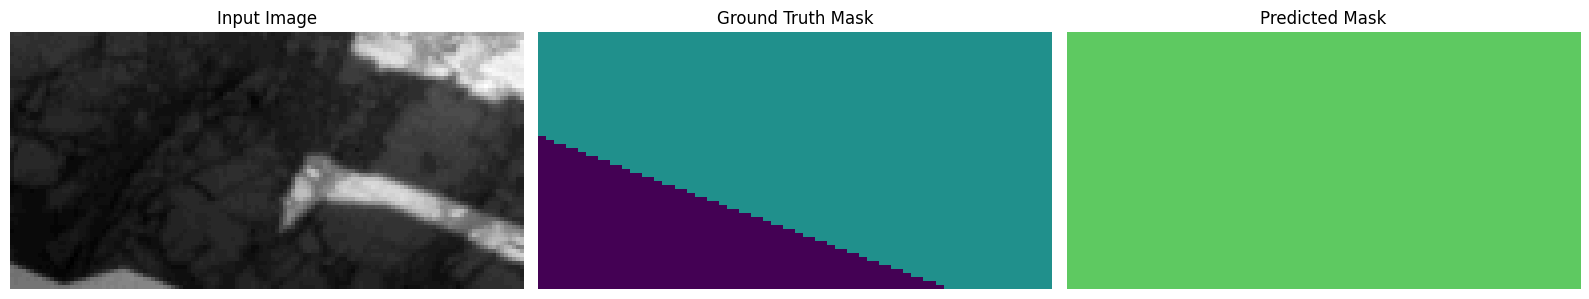

9/9 - 4s - 422ms/step - accuracy: 0.6344 - loss: 5.0675 - mean_iou: 0.4265 - val_accuracy: 0.3536 - val_loss: 7.6224 - val_mean_iou: 0.1666
Epoch 17/1000
9/9 - 3s - 378ms/step - accuracy: 0.6284 - loss: 5.0815 - mean_iou: 0.4196 - val_accuracy: 0.2501 - val_loss: 10.7398 - val_mean_iou: 0.0666
Epoch 18/1000
9/9 - 3s - 378ms/step - accuracy: 0.6227 - loss: 5.0932 - mean_iou: 0.4120 - val_accuracy: 0.2491 - val_loss: 8.7964 - val_mean_iou: 0.0884
Epoch 19/1000
9/9 - 3s - 377ms/step - accuracy: 0.6314 - loss: 5.0708 - mean_iou: 0.4221 - val_accuracy: 0.3207 - val_loss: 7.9366 - val_mean_iou: 0.1629
Epoch 20/1000
9/9 - 3s - 379ms/step - accuracy: 0.6247 - loss: 5.0829 - mean_iou: 0.4120 - val_accuracy: 0.3237 - val_loss: 7.9667 - val_mean_iou: 0.1463
Epoch 21/1000


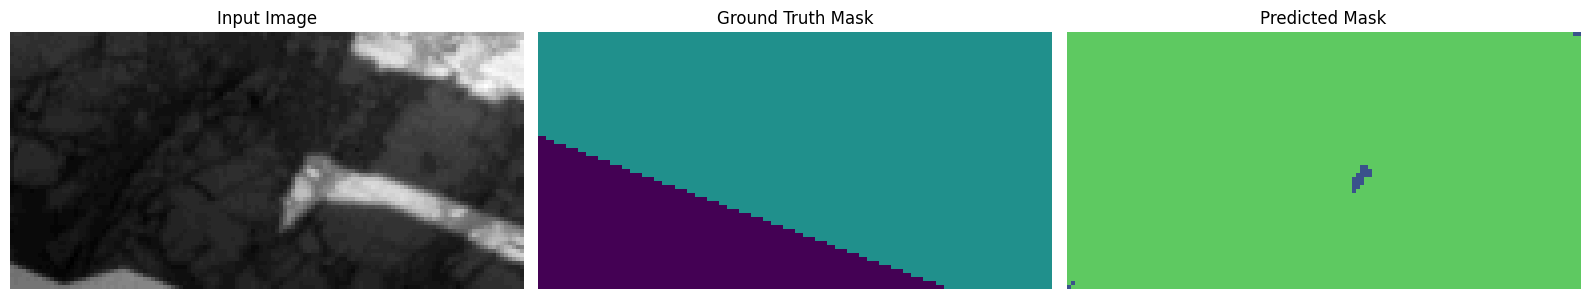

9/9 - 4s - 422ms/step - accuracy: 0.6294 - loss: 5.0717 - mean_iou: 0.4185 - val_accuracy: 0.3537 - val_loss: 8.0514 - val_mean_iou: 0.1737
Epoch 22/1000
9/9 - 3s - 377ms/step - accuracy: 0.6329 - loss: 5.0606 - mean_iou: 0.4232 - val_accuracy: 0.3664 - val_loss: 8.2622 - val_mean_iou: 0.1549
Epoch 23/1000
9/9 - 3s - 382ms/step - accuracy: 0.6324 - loss: 5.0593 - mean_iou: 0.4221 - val_accuracy: 0.4812 - val_loss: 6.4241 - val_mean_iou: 0.2713
Epoch 24/1000
9/9 - 3s - 378ms/step - accuracy: 0.6425 - loss: 5.0334 - mean_iou: 0.4337 - val_accuracy: 0.3395 - val_loss: 6.8409 - val_mean_iou: 0.1344
Epoch 25/1000
9/9 - 3s - 378ms/step - accuracy: 0.6414 - loss: 5.0312 - mean_iou: 0.4352 - val_accuracy: 0.3957 - val_loss: 6.4135 - val_mean_iou: 0.1895
Epoch 26/1000


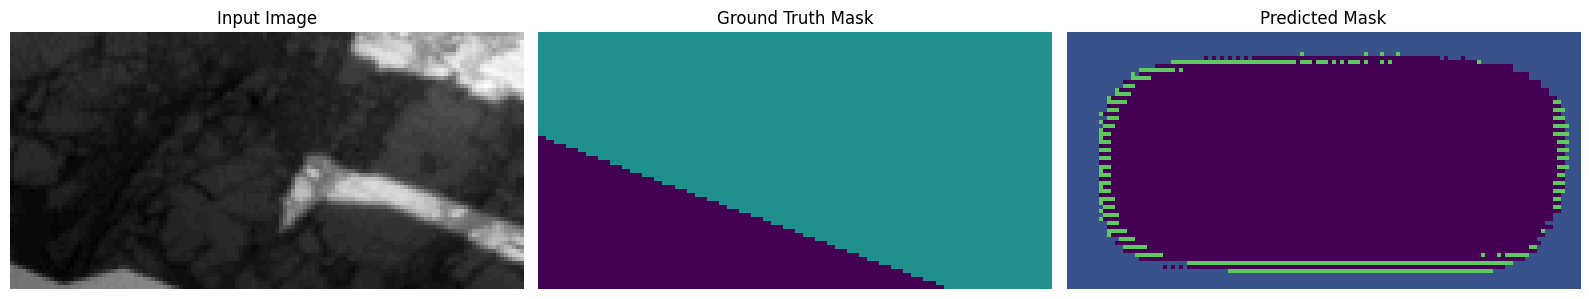

9/9 - 4s - 418ms/step - accuracy: 0.6452 - loss: 5.0272 - mean_iou: 0.4389 - val_accuracy: 0.3639 - val_loss: 7.4296 - val_mean_iou: 0.1323
Epoch 27/1000
9/9 - 3s - 377ms/step - accuracy: 0.6468 - loss: 5.0191 - mean_iou: 0.4408 - val_accuracy: 0.3782 - val_loss: 7.4070 - val_mean_iou: 0.1505
Epoch 28/1000
9/9 - 3s - 384ms/step - accuracy: 0.6493 - loss: 5.0185 - mean_iou: 0.4420 - val_accuracy: 0.5093 - val_loss: 6.2520 - val_mean_iou: 0.2919
Epoch 29/1000
9/9 - 3s - 384ms/step - accuracy: 0.6529 - loss: 5.0090 - mean_iou: 0.4484 - val_accuracy: 0.5227 - val_loss: 5.7755 - val_mean_iou: 0.3191
Epoch 30/1000
9/9 - 3s - 380ms/step - accuracy: 0.6393 - loss: 5.0364 - mean_iou: 0.4300 - val_accuracy: 0.3897 - val_loss: 6.7531 - val_mean_iou: 0.1723
Epoch 31/1000


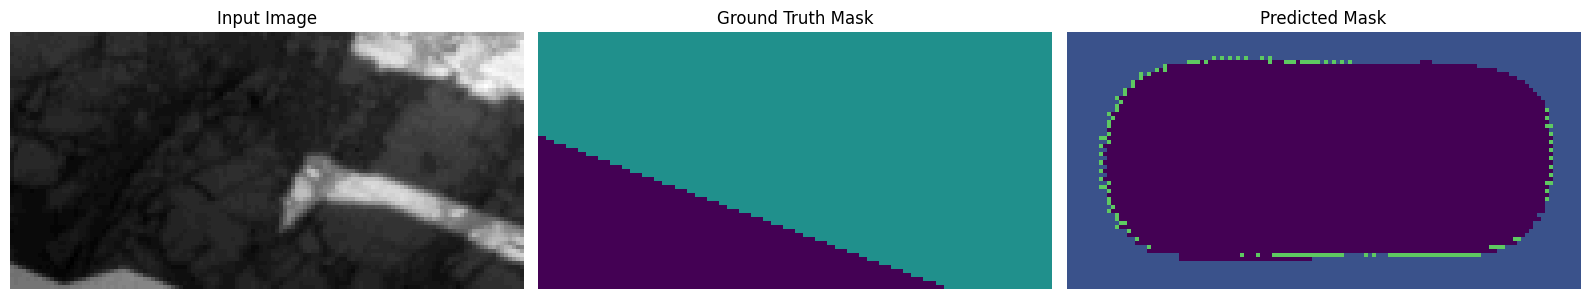

9/9 - 4s - 418ms/step - accuracy: 0.6332 - loss: 5.0404 - mean_iou: 0.4246 - val_accuracy: 0.4007 - val_loss: 7.0912 - val_mean_iou: 0.1698
Epoch 32/1000
9/9 - 3s - 377ms/step - accuracy: 0.6509 - loss: 5.0092 - mean_iou: 0.4434 - val_accuracy: 0.4752 - val_loss: 6.5369 - val_mean_iou: 0.2406
Epoch 33/1000
9/9 - 3s - 383ms/step - accuracy: 0.6571 - loss: 4.9910 - mean_iou: 0.4518 - val_accuracy: 0.6024 - val_loss: 5.4774 - val_mean_iou: 0.3839
Epoch 34/1000
9/9 - 3s - 383ms/step - accuracy: 0.6588 - loss: 4.9836 - mean_iou: 0.4552 - val_accuracy: 0.6288 - val_loss: 5.1903 - val_mean_iou: 0.4114
Epoch 35/1000
9/9 - 3s - 379ms/step - accuracy: 0.6585 - loss: 4.9836 - mean_iou: 0.4550 - val_accuracy: 0.5660 - val_loss: 5.4836 - val_mean_iou: 0.3348
Epoch 36/1000


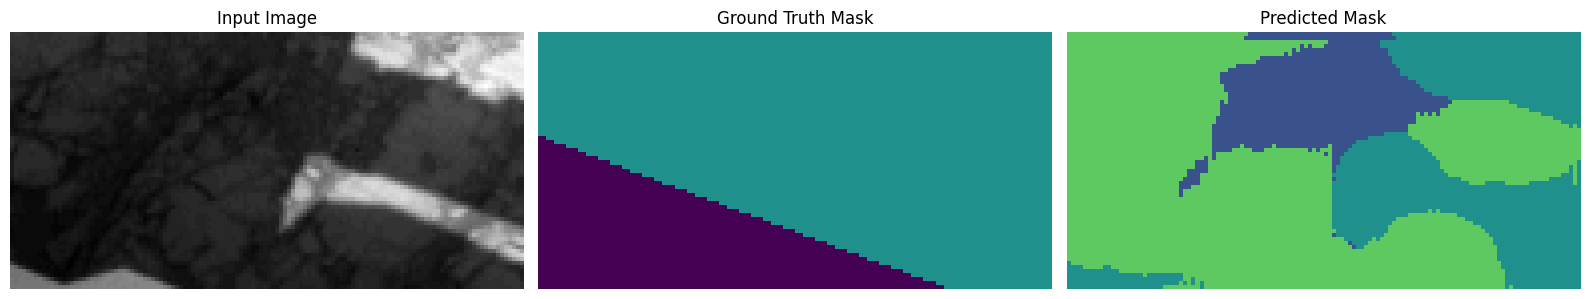

9/9 - 4s - 423ms/step - accuracy: 0.6545 - loss: 4.9889 - mean_iou: 0.4494 - val_accuracy: 0.6296 - val_loss: 5.2646 - val_mean_iou: 0.4257
Epoch 37/1000
9/9 - 3s - 377ms/step - accuracy: 0.6601 - loss: 4.9818 - mean_iou: 0.4562 - val_accuracy: 0.5643 - val_loss: 5.5064 - val_mean_iou: 0.3663
Epoch 38/1000
9/9 - 3s - 378ms/step - accuracy: 0.6619 - loss: 4.9704 - mean_iou: 0.4596 - val_accuracy: 0.6194 - val_loss: 5.1680 - val_mean_iou: 0.4043
Epoch 39/1000
9/9 - 3s - 378ms/step - accuracy: 0.6630 - loss: 4.9651 - mean_iou: 0.4610 - val_accuracy: 0.5946 - val_loss: 5.2512 - val_mean_iou: 0.3796
Epoch 40/1000
9/9 - 3s - 378ms/step - accuracy: 0.6651 - loss: 4.9640 - mean_iou: 0.4629 - val_accuracy: 0.5903 - val_loss: 5.2386 - val_mean_iou: 0.3810
Epoch 41/1000


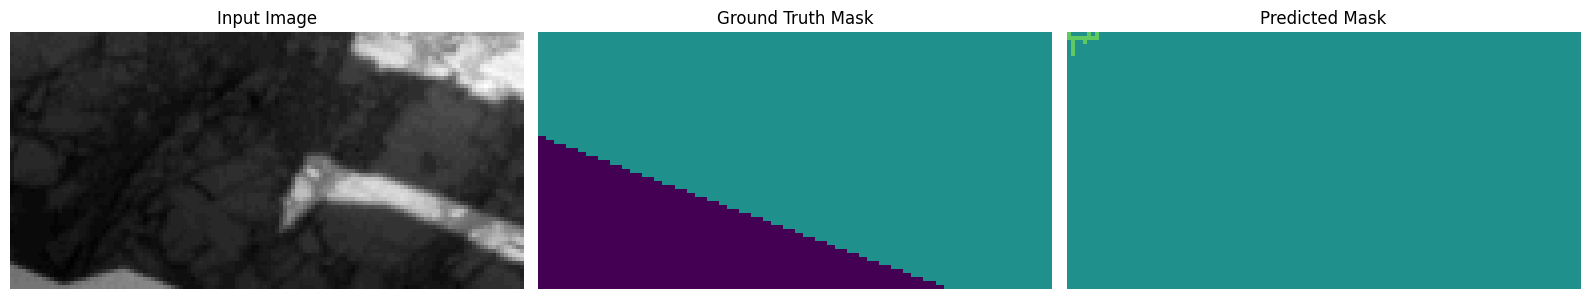

9/9 - 4s - 418ms/step - accuracy: 0.6542 - loss: 4.9873 - mean_iou: 0.4477 - val_accuracy: 0.6142 - val_loss: 5.1360 - val_mean_iou: 0.3939
Epoch 42/1000
9/9 - 3s - 379ms/step - accuracy: 0.6630 - loss: 4.9635 - mean_iou: 0.4591 - val_accuracy: 0.6326 - val_loss: 5.1379 - val_mean_iou: 0.4169
Epoch 43/1000
9/9 - 3s - 377ms/step - accuracy: 0.6629 - loss: 4.9635 - mean_iou: 0.4604 - val_accuracy: 0.6343 - val_loss: 5.0856 - val_mean_iou: 0.4227
Epoch 44/1000
9/9 - 3s - 377ms/step - accuracy: 0.6649 - loss: 4.9565 - mean_iou: 0.4640 - val_accuracy: 0.6183 - val_loss: 5.1711 - val_mean_iou: 0.4037
Epoch 45/1000
9/9 - 3s - 377ms/step - accuracy: 0.6715 - loss: 4.9517 - mean_iou: 0.4707 - val_accuracy: 0.4800 - val_loss: 6.3659 - val_mean_iou: 0.2862
Epoch 46/1000


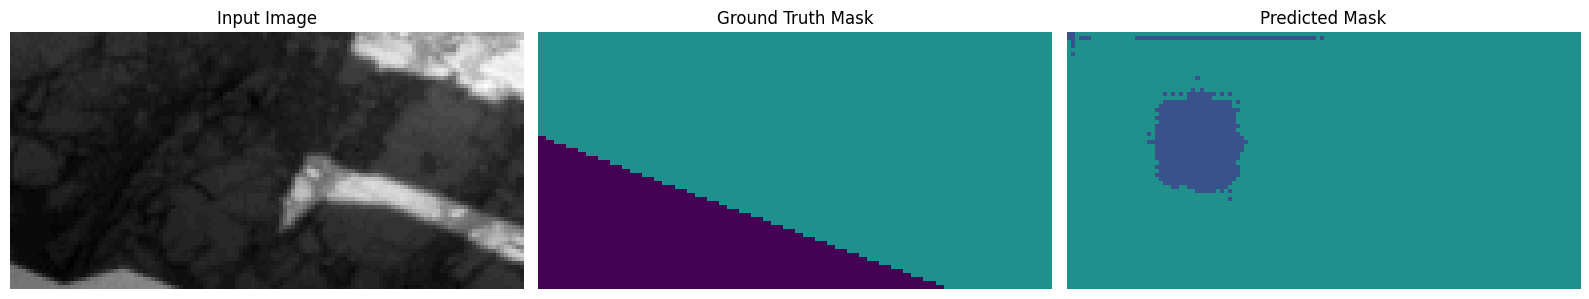

9/9 - 4s - 424ms/step - accuracy: 0.6672 - loss: 4.9496 - mean_iou: 0.4665 - val_accuracy: 0.6357 - val_loss: 5.0757 - val_mean_iou: 0.4308
Epoch 47/1000
9/9 - 3s - 383ms/step - accuracy: 0.6697 - loss: 4.9496 - mean_iou: 0.4695 - val_accuracy: 0.6487 - val_loss: 5.0577 - val_mean_iou: 0.4448
Epoch 48/1000
9/9 - 3s - 377ms/step - accuracy: 0.6662 - loss: 4.9517 - mean_iou: 0.4659 - val_accuracy: 0.6383 - val_loss: 5.0425 - val_mean_iou: 0.4296
Epoch 49/1000
9/9 - 3s - 377ms/step - accuracy: 0.6659 - loss: 4.9461 - mean_iou: 0.5835 - val_accuracy: 0.6423 - val_loss: 5.0326 - val_mean_iou: 0.4412
Epoch 50/1000
9/9 - 3s - 382ms/step - accuracy: 0.6693 - loss: 4.9385 - mean_iou: 0.4706 - val_accuracy: 0.6540 - val_loss: 5.0410 - val_mean_iou: 0.4494
Epoch 51/1000


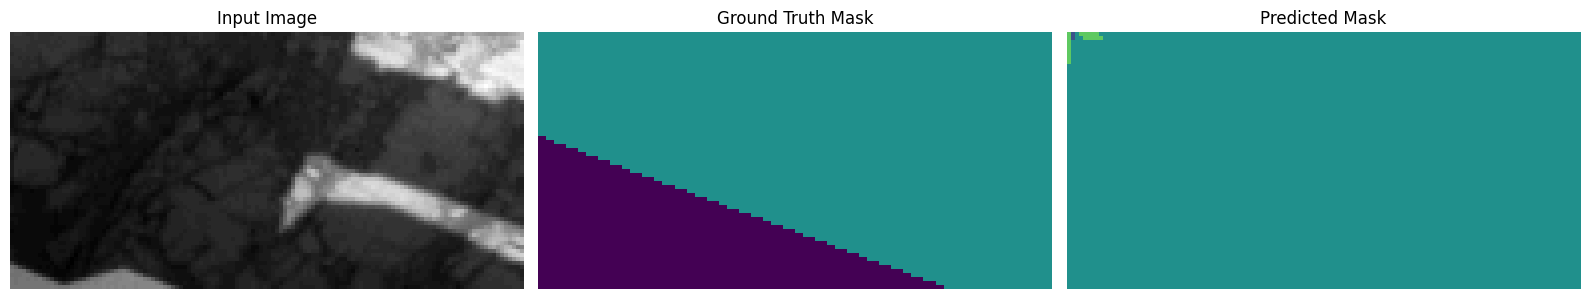

9/9 - 4s - 408ms/step - accuracy: 0.6752 - loss: 4.9282 - mean_iou: 0.4768 - val_accuracy: 0.5798 - val_loss: 5.2493 - val_mean_iou: 0.3619
Epoch 52/1000
9/9 - 3s - 379ms/step - accuracy: 0.6647 - loss: 4.9484 - mean_iou: 0.4625 - val_accuracy: 0.5435 - val_loss: 5.3888 - val_mean_iou: 0.2945
Epoch 53/1000
9/9 - 3s - 378ms/step - accuracy: 0.6716 - loss: 4.9338 - mean_iou: 0.4712 - val_accuracy: 0.5435 - val_loss: 5.6461 - val_mean_iou: 0.3422
Epoch 54/1000
9/9 - 3s - 378ms/step - accuracy: 0.6757 - loss: 4.9250 - mean_iou: 0.4757 - val_accuracy: 0.5764 - val_loss: 5.3065 - val_mean_iou: 0.3569
Epoch 55/1000
9/9 - 3s - 377ms/step - accuracy: 0.6700 - loss: 4.9312 - mean_iou: 0.4683 - val_accuracy: 0.5970 - val_loss: 5.3511 - val_mean_iou: 0.3788
Epoch 56/1000


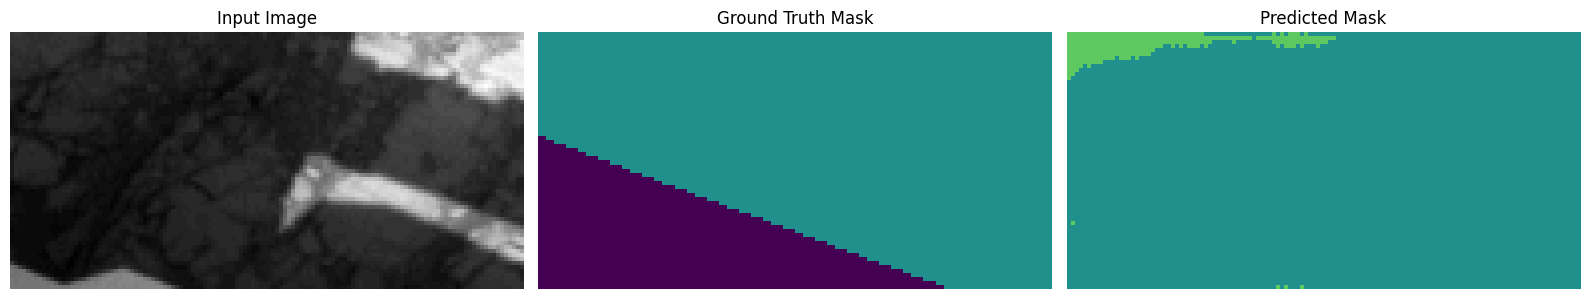

9/9 - 4s - 417ms/step - accuracy: 0.6674 - loss: 4.9417 - mean_iou: 0.4680 - val_accuracy: 0.5576 - val_loss: 5.5246 - val_mean_iou: 0.3211
Epoch 57/1000
9/9 - 3s - 378ms/step - accuracy: 0.6653 - loss: 4.9562 - mean_iou: 0.4637 - val_accuracy: 0.6524 - val_loss: 5.0638 - val_mean_iou: 0.4429
Epoch 58/1000
9/9 - 3s - 378ms/step - accuracy: 0.6740 - loss: 4.9388 - mean_iou: 0.4740 - val_accuracy: 0.5579 - val_loss: 5.4008 - val_mean_iou: 0.3519
Epoch 59/1000
9/9 - 3s - 384ms/step - accuracy: 0.6757 - loss: 4.9221 - mean_iou: 0.4764 - val_accuracy: 0.6576 - val_loss: 5.0086 - val_mean_iou: 0.4543
Epoch 60/1000
9/9 - 3s - 377ms/step - accuracy: 0.6725 - loss: 4.9325 - mean_iou: 0.4720 - val_accuracy: 0.6454 - val_loss: 5.0246 - val_mean_iou: 0.4377
Epoch 61/1000


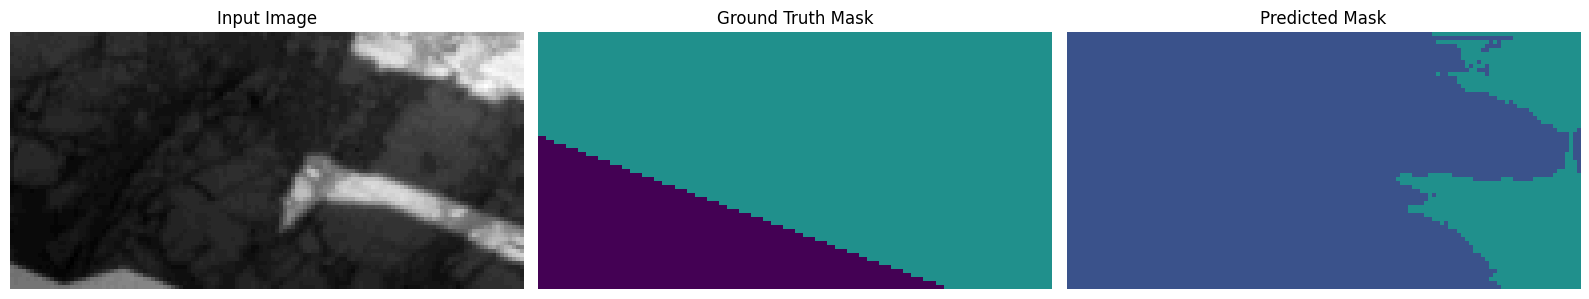

9/9 - 4s - 408ms/step - accuracy: 0.6732 - loss: 4.9298 - mean_iou: 0.4727 - val_accuracy: 0.6339 - val_loss: 5.0846 - val_mean_iou: 0.4224
Epoch 62/1000
9/9 - 3s - 378ms/step - accuracy: 0.6792 - loss: 4.9160 - mean_iou: 0.4809 - val_accuracy: 0.4838 - val_loss: 5.8817 - val_mean_iou: 0.2512
Epoch 63/1000
9/9 - 3s - 378ms/step - accuracy: 0.6733 - loss: 4.9295 - mean_iou: 0.4741 - val_accuracy: 0.6117 - val_loss: 5.2642 - val_mean_iou: 0.4019
Epoch 64/1000
9/9 - 3s - 380ms/step - accuracy: 0.6736 - loss: 4.9245 - mean_iou: 0.4730 - val_accuracy: 0.6001 - val_loss: 5.3331 - val_mean_iou: 0.3960
Epoch 65/1000
9/9 - 3s - 378ms/step - accuracy: 0.6823 - loss: 4.9131 - mean_iou: 0.4838 - val_accuracy: 0.5602 - val_loss: 5.3720 - val_mean_iou: 0.3358
Epoch 66/1000


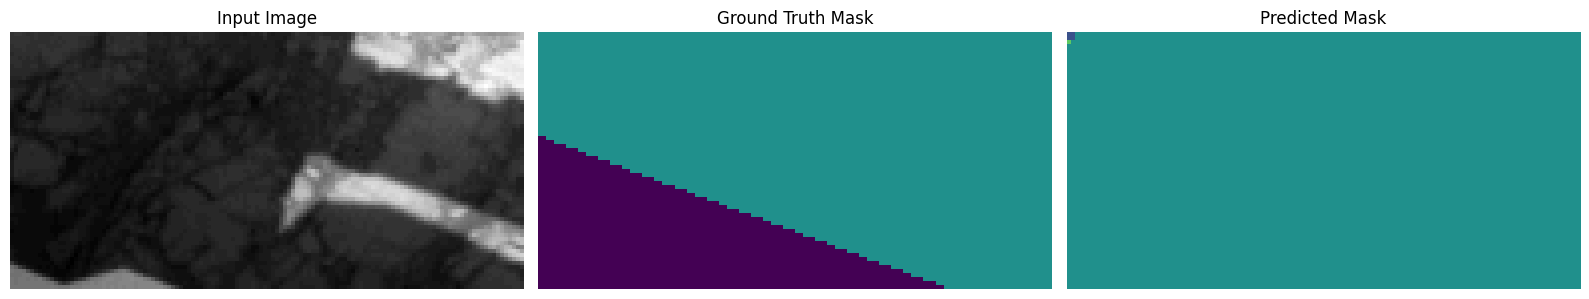

9/9 - 4s - 420ms/step - accuracy: 0.6792 - loss: 4.9173 - mean_iou: 0.4822 - val_accuracy: 0.6187 - val_loss: 5.1328 - val_mean_iou: 0.4088
Epoch 67/1000
9/9 - 3s - 377ms/step - accuracy: 0.6833 - loss: 4.9048 - mean_iou: 0.4870 - val_accuracy: 0.6005 - val_loss: 5.1547 - val_mean_iou: 0.3975
Epoch 68/1000
9/9 - 3s - 378ms/step - accuracy: 0.6862 - loss: 4.9007 - mean_iou: 0.4895 - val_accuracy: 0.6023 - val_loss: 5.3143 - val_mean_iou: 0.3995
Epoch 69/1000
9/9 - 3s - 379ms/step - accuracy: 0.6859 - loss: 4.8980 - mean_iou: 0.4920 - val_accuracy: 0.6354 - val_loss: 5.0930 - val_mean_iou: 0.4231
Epoch 70/1000
9/9 - 3s - 378ms/step - accuracy: 0.6876 - loss: 4.8943 - mean_iou: 0.4943 - val_accuracy: 0.6473 - val_loss: 5.0105 - val_mean_iou: 0.4373
Epoch 71/1000


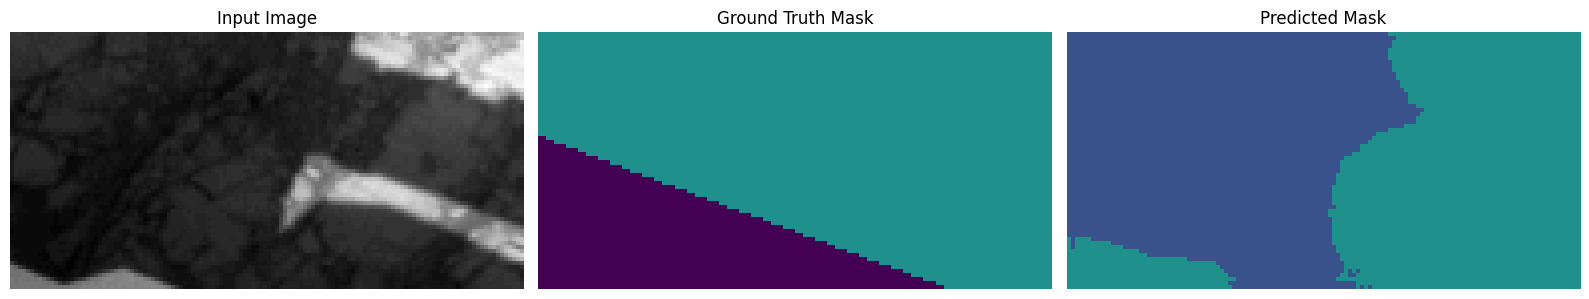

9/9 - 4s - 413ms/step - accuracy: 0.6876 - loss: 4.8959 - mean_iou: 0.4937 - val_accuracy: 0.6502 - val_loss: 5.0159 - val_mean_iou: 0.4399
Epoch 72/1000
9/9 - 3s - 377ms/step - accuracy: 0.6871 - loss: 4.8948 - mean_iou: 0.4925 - val_accuracy: 0.5073 - val_loss: 5.4393 - val_mean_iou: 0.2650
Epoch 73/1000
9/9 - 3s - 378ms/step - accuracy: 0.6862 - loss: 4.8950 - mean_iou: 0.4941 - val_accuracy: 0.5597 - val_loss: 5.4483 - val_mean_iou: 0.3609
Epoch 74/1000
9/9 - 3s - 378ms/step - accuracy: 0.6757 - loss: 4.9230 - mean_iou: 0.4850 - val_accuracy: 0.4790 - val_loss: 5.8653 - val_mean_iou: 0.2489
Epoch 75/1000
9/9 - 3s - 379ms/step - accuracy: 0.6770 - loss: 4.9205 - mean_iou: 0.4869 - val_accuracy: 0.5905 - val_loss: 5.2828 - val_mean_iou: 0.3779
Epoch 76/1000


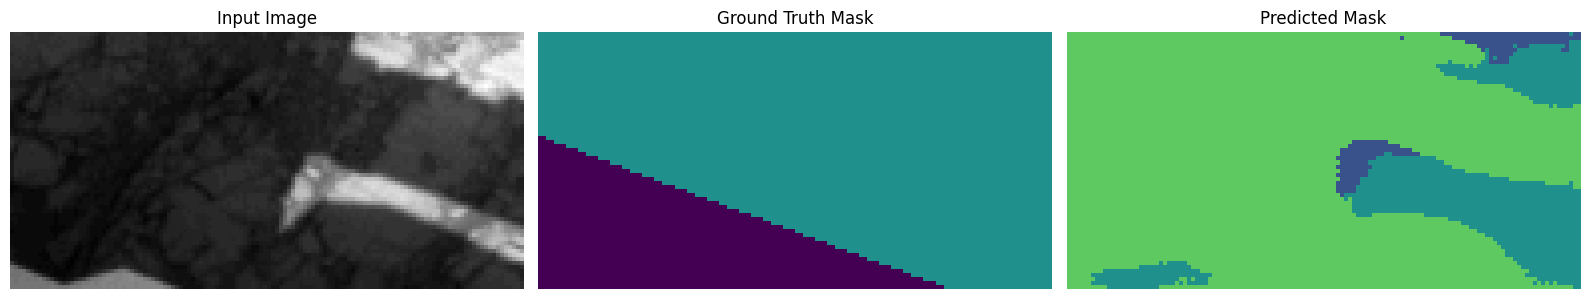

9/9 - 4s - 411ms/step - accuracy: 0.6781 - loss: 4.9130 - mean_iou: 0.4841 - val_accuracy: 0.4927 - val_loss: 5.6304 - val_mean_iou: 0.2736
Epoch 77/1000
9/9 - 3s - 377ms/step - accuracy: 0.6792 - loss: 4.9117 - mean_iou: 0.4938 - val_accuracy: 0.6217 - val_loss: 5.1543 - val_mean_iou: 0.4197
Epoch 78/1000
9/9 - 3s - 378ms/step - accuracy: 0.6783 - loss: 4.9115 - mean_iou: 0.4898 - val_accuracy: 0.5974 - val_loss: 5.2139 - val_mean_iou: 0.3904
Epoch 79/1000
9/9 - 3s - 377ms/step - accuracy: 0.6775 - loss: 4.9129 - mean_iou: 0.4895 - val_accuracy: 0.6462 - val_loss: 4.9965 - val_mean_iou: 0.4453
Epoch 80/1000
9/9 - 3s - 378ms/step - accuracy: 0.6876 - loss: 4.8905 - mean_iou: 0.5034 - val_accuracy: 0.6350 - val_loss: 5.0717 - val_mean_iou: 0.4334
Epoch 81/1000


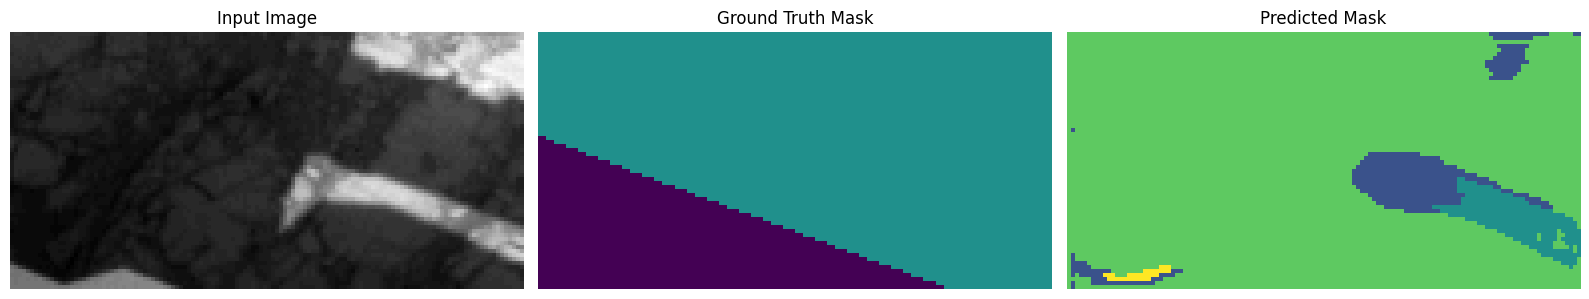

9/9 - 4s - 418ms/step - accuracy: 0.6781 - loss: 4.9074 - mean_iou: 0.4926 - val_accuracy: 0.5915 - val_loss: 5.1869 - val_mean_iou: 0.3807
Epoch 82/1000
9/9 - 3s - 379ms/step - accuracy: 0.6815 - loss: 4.9041 - mean_iou: 0.4997 - val_accuracy: 0.6017 - val_loss: 5.1421 - val_mean_iou: 0.3800
Epoch 83/1000
9/9 - 3s - 379ms/step - accuracy: 0.6879 - loss: 4.8880 - mean_iou: 0.5017 - val_accuracy: 0.5375 - val_loss: 5.5602 - val_mean_iou: 0.3107
Epoch 84/1000
9/9 - 3s - 378ms/step - accuracy: 0.6892 - loss: 4.8751 - mean_iou: 0.5120 - val_accuracy: 0.4473 - val_loss: 5.9003 - val_mean_iou: 0.2054
Epoch 85/1000
9/9 - 3s - 385ms/step - accuracy: 0.6894 - loss: 4.8840 - mean_iou: 0.5154 - val_accuracy: 0.6140 - val_loss: 5.1799 - val_mean_iou: 0.5039
Epoch 86/1000


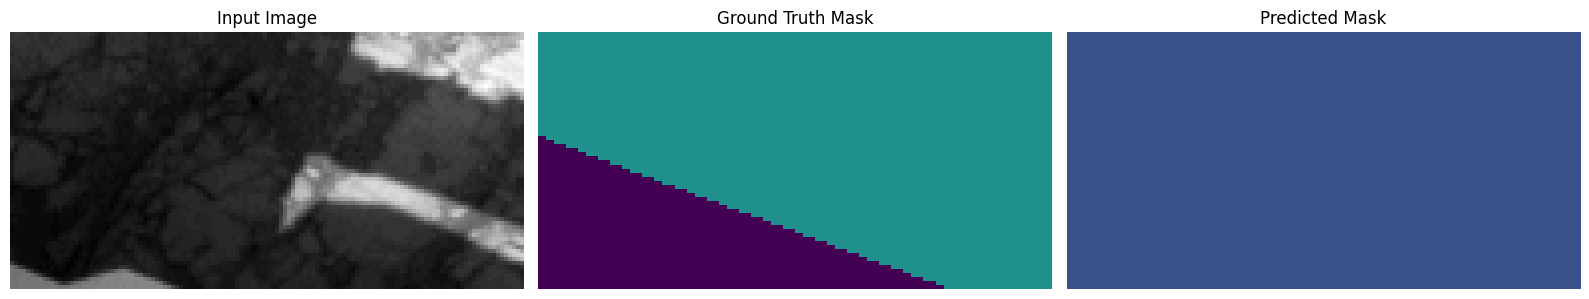

9/9 - 4s - 424ms/step - accuracy: 0.6867 - loss: 4.8862 - mean_iou: 0.5129 - val_accuracy: 0.6171 - val_loss: 5.0842 - val_mean_iou: 0.5174
Epoch 87/1000
9/9 - 3s - 379ms/step - accuracy: 0.6879 - loss: 4.8845 - mean_iou: 0.5122 - val_accuracy: 0.4042 - val_loss: 6.3484 - val_mean_iou: 0.1643
Epoch 88/1000
9/9 - 3s - 384ms/step - accuracy: 0.6872 - loss: 4.8919 - mean_iou: 0.6348 - val_accuracy: 0.6534 - val_loss: 4.9748 - val_mean_iou: 0.5798
Epoch 89/1000
9/9 - 3s - 378ms/step - accuracy: 0.6906 - loss: 4.8785 - mean_iou: 0.5191 - val_accuracy: 0.6129 - val_loss: 5.1435 - val_mean_iou: 0.5204
Epoch 90/1000
9/9 - 3s - 378ms/step - accuracy: 0.6893 - loss: 4.8746 - mean_iou: 0.6444 - val_accuracy: 0.6532 - val_loss: 5.0302 - val_mean_iou: 0.5686
Epoch 91/1000


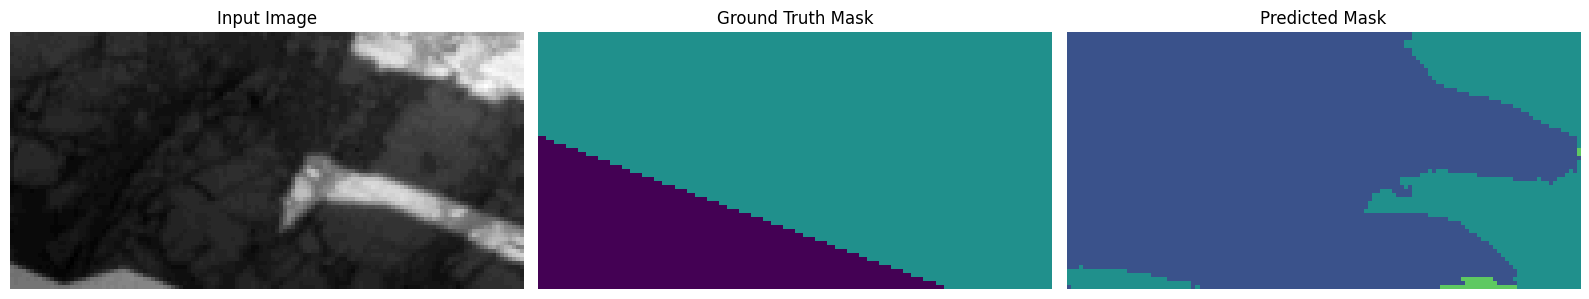

9/9 - 4s - 466ms/step - accuracy: 0.6937 - loss: 4.8668 - mean_iou: 0.6571 - val_accuracy: 0.6528 - val_loss: 5.0101 - val_mean_iou: 0.5830
Epoch 92/1000
9/9 - 3s - 384ms/step - accuracy: 0.6840 - loss: 4.8853 - mean_iou: 0.6386 - val_accuracy: 0.6817 - val_loss: 4.9076 - val_mean_iou: 0.6232
Epoch 93/1000
9/9 - 3s - 380ms/step - accuracy: 0.6952 - loss: 4.8646 - mean_iou: 0.6466 - val_accuracy: 0.5570 - val_loss: 5.1956 - val_mean_iou: 0.4225
Epoch 94/1000
9/9 - 3s - 379ms/step - accuracy: 0.6848 - loss: 4.8857 - mean_iou: 0.5065 - val_accuracy: 0.6114 - val_loss: 5.1858 - val_mean_iou: 0.4085
Epoch 95/1000
9/9 - 3s - 378ms/step - accuracy: 0.6874 - loss: 4.8835 - mean_iou: 0.5127 - val_accuracy: 0.5648 - val_loss: 5.5198 - val_mean_iou: 0.4684
Epoch 96/1000


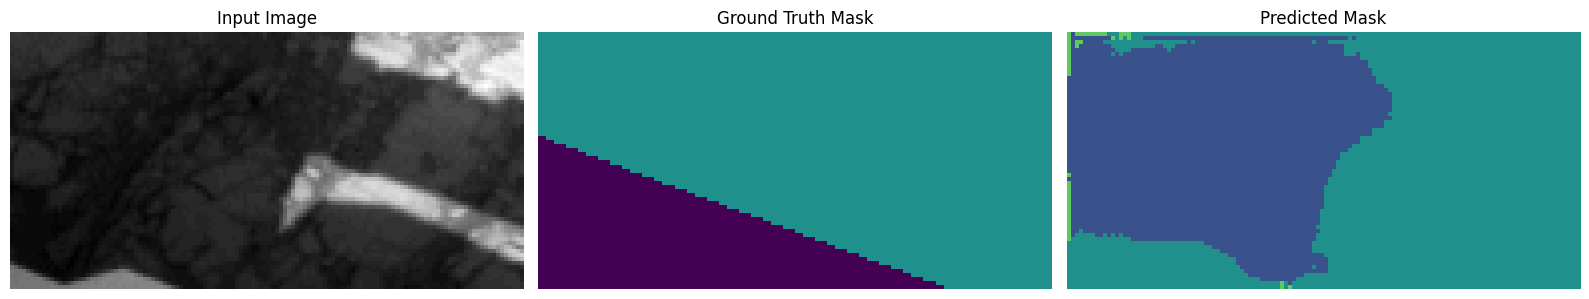

9/9 - 4s - 408ms/step - accuracy: 0.6892 - loss: 4.8779 - mean_iou: 0.5237 - val_accuracy: 0.6164 - val_loss: 5.1684 - val_mean_iou: 0.5345
Epoch 97/1000
9/9 - 3s - 378ms/step - accuracy: 0.6936 - loss: 4.8685 - mean_iou: 0.6598 - val_accuracy: 0.5902 - val_loss: 5.2156 - val_mean_iou: 0.4859
Epoch 98/1000
9/9 - 3s - 379ms/step - accuracy: 0.7000 - loss: 4.8526 - mean_iou: 0.5329 - val_accuracy: 0.4590 - val_loss: 5.8041 - val_mean_iou: 0.2874
Epoch 99/1000
9/9 - 3s - 379ms/step - accuracy: 0.6866 - loss: 4.8807 - mean_iou: 0.6512 - val_accuracy: 0.4489 - val_loss: 6.1078 - val_mean_iou: 0.2657
Epoch 100/1000
9/9 - 3s - 378ms/step - accuracy: 0.6859 - loss: 4.8857 - mean_iou: 0.6468 - val_accuracy: 0.6665 - val_loss: 4.9710 - val_mean_iou: 0.6127
Epoch 101/1000


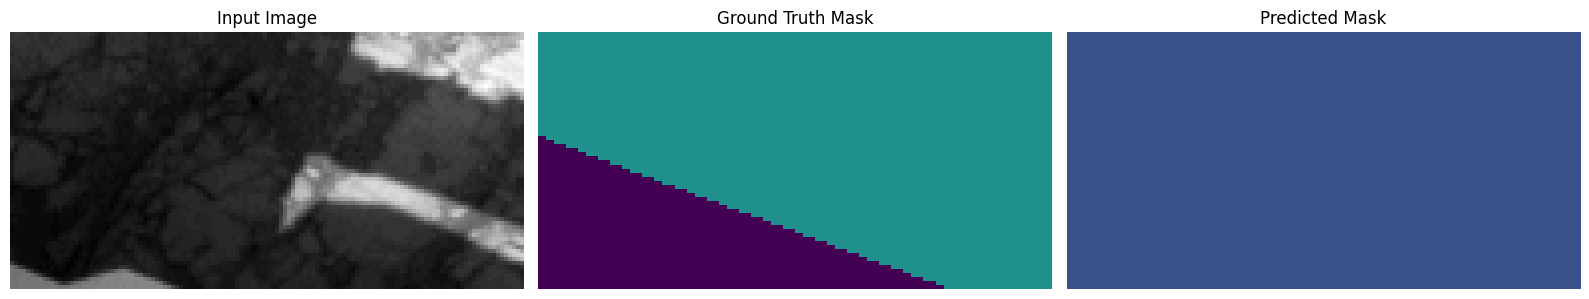

9/9 - 4s - 407ms/step - accuracy: 0.6886 - loss: 4.8763 - mean_iou: 0.6484 - val_accuracy: 0.5722 - val_loss: 5.3559 - val_mean_iou: 0.4504
Epoch 102/1000
9/9 - 3s - 378ms/step - accuracy: 0.6912 - loss: 4.8659 - mean_iou: 0.6626 - val_accuracy: 0.5169 - val_loss: 5.5663 - val_mean_iou: 0.3678
Epoch 103/1000
9/9 - 3s - 379ms/step - accuracy: 0.6928 - loss: 4.8610 - mean_iou: 0.6624 - val_accuracy: 0.6098 - val_loss: 5.2719 - val_mean_iou: 0.5428
Epoch 104/1000
9/9 - 3s - 378ms/step - accuracy: 0.6908 - loss: 4.8681 - mean_iou: 0.5222 - val_accuracy: 0.5161 - val_loss: 5.9025 - val_mean_iou: 0.4259
Epoch 105/1000
9/9 - 3s - 379ms/step - accuracy: 0.6889 - loss: 4.8737 - mean_iou: 0.6539 - val_accuracy: 0.6592 - val_loss: 5.0365 - val_mean_iou: 0.6049
Epoch 106/1000


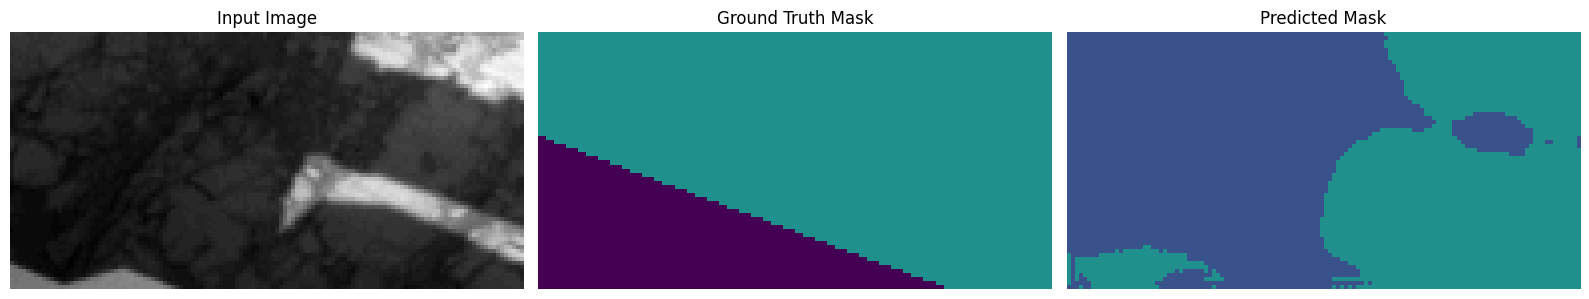

9/9 - 4s - 419ms/step - accuracy: 0.6871 - loss: 4.8827 - mean_iou: 0.6416 - val_accuracy: 0.6765 - val_loss: 4.9263 - val_mean_iou: 0.6217
Epoch 107/1000
9/9 - 3s - 383ms/step - accuracy: 0.6955 - loss: 4.8606 - mean_iou: 0.6581 - val_accuracy: 0.6761 - val_loss: 4.9362 - val_mean_iou: 0.6365
Epoch 108/1000
9/9 - 3s - 377ms/step - accuracy: 0.7010 - loss: 4.8443 - mean_iou: 0.6832 - val_accuracy: 0.6698 - val_loss: 4.9314 - val_mean_iou: 0.6197
Epoch 109/1000
9/9 - 3s - 378ms/step - accuracy: 0.6982 - loss: 4.8403 - mean_iou: 0.6766 - val_accuracy: 0.6069 - val_loss: 5.1943 - val_mean_iou: 0.5104
Epoch 110/1000
9/9 - 3s - 378ms/step - accuracy: 0.6966 - loss: 4.8498 - mean_iou: 0.6724 - val_accuracy: 0.6321 - val_loss: 5.0677 - val_mean_iou: 0.5543
Epoch 111/1000


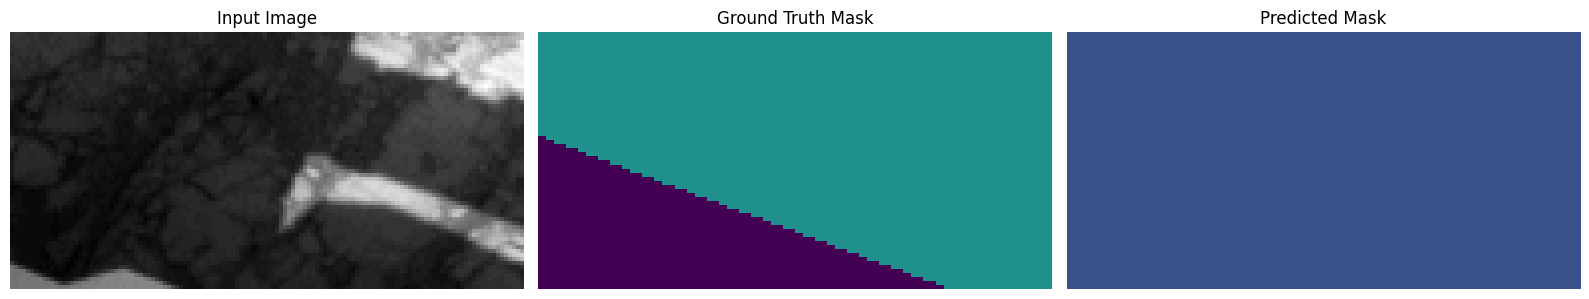

9/9 - 4s - 418ms/step - accuracy: 0.6905 - loss: 4.8663 - mean_iou: 0.6611 - val_accuracy: 0.6235 - val_loss: 5.1149 - val_mean_iou: 0.5259
Epoch 112/1000
9/9 - 3s - 380ms/step - accuracy: 0.6983 - loss: 4.8434 - mean_iou: 0.6732 - val_accuracy: 0.6564 - val_loss: 5.0411 - val_mean_iou: 0.4872
Epoch 113/1000
9/9 - 3s - 377ms/step - accuracy: 0.7004 - loss: 4.8372 - mean_iou: 0.5465 - val_accuracy: 0.5524 - val_loss: 5.5721 - val_mean_iou: 0.3835
Epoch 114/1000
9/9 - 3s - 378ms/step - accuracy: 0.6977 - loss: 4.8451 - mean_iou: 0.6836 - val_accuracy: 0.6404 - val_loss: 5.1294 - val_mean_iou: 0.6008
Epoch 115/1000
9/9 - 3s - 378ms/step - accuracy: 0.6907 - loss: 4.8646 - mean_iou: 0.6678 - val_accuracy: 0.6001 - val_loss: 5.2513 - val_mean_iou: 0.4998
Epoch 116/1000


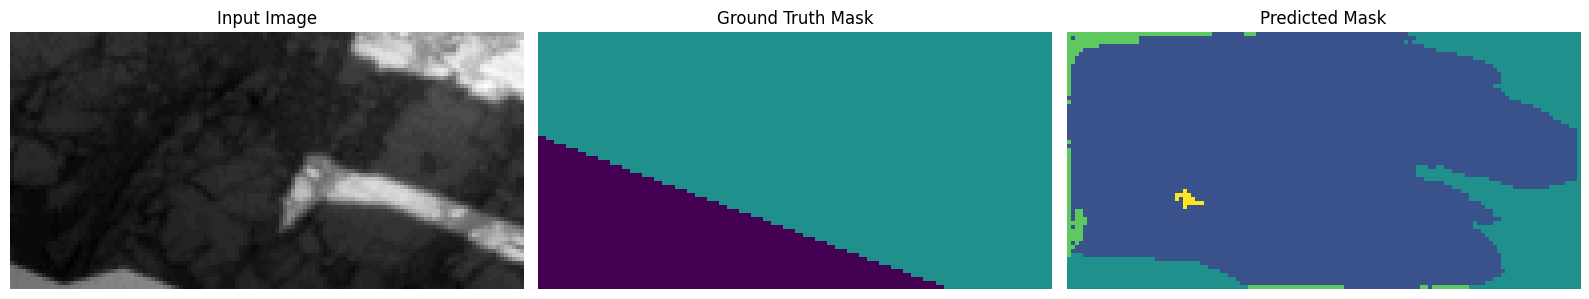

9/9 - 4s - 418ms/step - accuracy: 0.6995 - loss: 4.8455 - mean_iou: 0.6747 - val_accuracy: 0.5797 - val_loss: 5.6036 - val_mean_iou: 0.5310
Epoch 117/1000
9/9 - 3s - 378ms/step - accuracy: 0.6964 - loss: 4.8570 - mean_iou: 0.5212 - val_accuracy: 0.6294 - val_loss: 5.1534 - val_mean_iou: 0.4213
Epoch 118/1000
9/9 - 3s - 378ms/step - accuracy: 0.6918 - loss: 4.8651 - mean_iou: 0.6520 - val_accuracy: 0.6701 - val_loss: 5.0134 - val_mean_iou: 0.6300
Epoch 119/1000
9/9 - 3s - 383ms/step - accuracy: 0.7005 - loss: 4.8335 - mean_iou: 0.6826 - val_accuracy: 0.6701 - val_loss: 4.9208 - val_mean_iou: 0.6435
Epoch 120/1000
9/9 - 3s - 382ms/step - accuracy: 0.7025 - loss: 4.8326 - mean_iou: 0.6882 - val_accuracy: 0.6945 - val_loss: 4.8847 - val_mean_iou: 0.6871
Epoch 121/1000


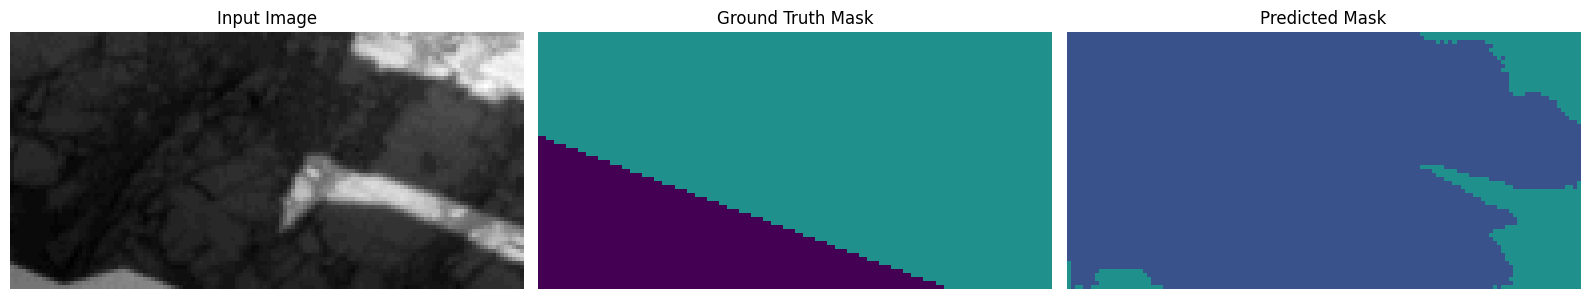

9/9 - 4s - 408ms/step - accuracy: 0.6967 - loss: 4.8492 - mean_iou: 0.6784 - val_accuracy: 0.6450 - val_loss: 5.0350 - val_mean_iou: 0.4742
Epoch 122/1000
9/9 - 3s - 377ms/step - accuracy: 0.6975 - loss: 4.8448 - mean_iou: 0.6764 - val_accuracy: 0.6684 - val_loss: 4.9842 - val_mean_iou: 0.5246
Epoch 123/1000
9/9 - 3s - 376ms/step - accuracy: 0.6998 - loss: 4.8336 - mean_iou: 0.5577 - val_accuracy: 0.6782 - val_loss: 4.9173 - val_mean_iou: 0.6611
Epoch 124/1000
9/9 - 3s - 377ms/step - accuracy: 0.7013 - loss: 4.8336 - mean_iou: 0.6815 - val_accuracy: 0.6629 - val_loss: 5.0444 - val_mean_iou: 0.5023
Epoch 125/1000
9/9 - 3s - 377ms/step - accuracy: 0.6977 - loss: 4.8412 - mean_iou: 0.6889 - val_accuracy: 0.6761 - val_loss: 4.8987 - val_mean_iou: 0.6352
Epoch 126/1000


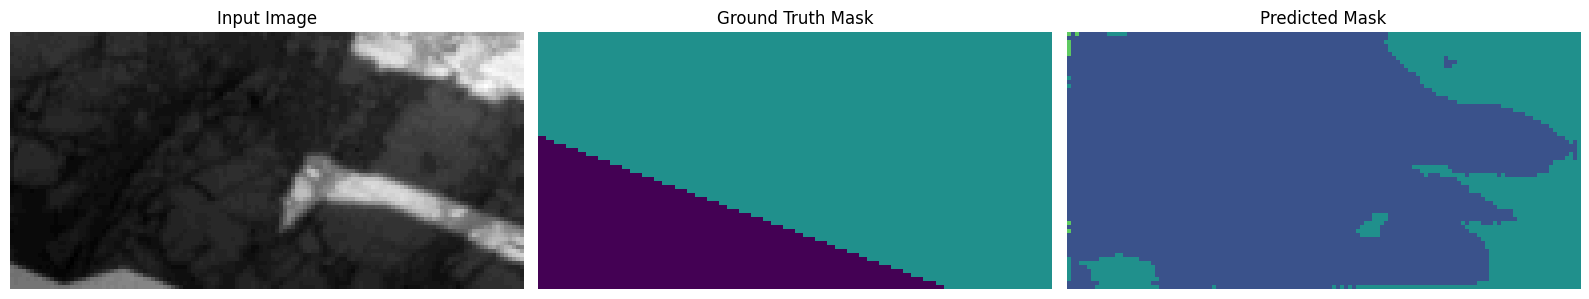

9/9 - 4s - 408ms/step - accuracy: 0.7000 - loss: 4.8345 - mean_iou: 0.6905 - val_accuracy: 0.6570 - val_loss: 4.9890 - val_mean_iou: 0.6176
Epoch 127/1000
9/9 - 3s - 377ms/step - accuracy: 0.7006 - loss: 4.8265 - mean_iou: 0.6976 - val_accuracy: 0.6930 - val_loss: 4.8535 - val_mean_iou: 0.6803
Epoch 128/1000
9/9 - 3s - 377ms/step - accuracy: 0.7063 - loss: 4.8217 - mean_iou: 0.5612 - val_accuracy: 0.6870 - val_loss: 4.9232 - val_mean_iou: 0.5385
Epoch 129/1000
9/9 - 3s - 377ms/step - accuracy: 0.7042 - loss: 4.8222 - mean_iou: 0.5680 - val_accuracy: 0.6763 - val_loss: 4.9858 - val_mean_iou: 0.5241
Epoch 130/1000
9/9 - 3s - 380ms/step - accuracy: 0.7006 - loss: 4.8230 - mean_iou: 0.7114 - val_accuracy: 0.6708 - val_loss: 4.9402 - val_mean_iou: 0.5154
Epoch 131/1000


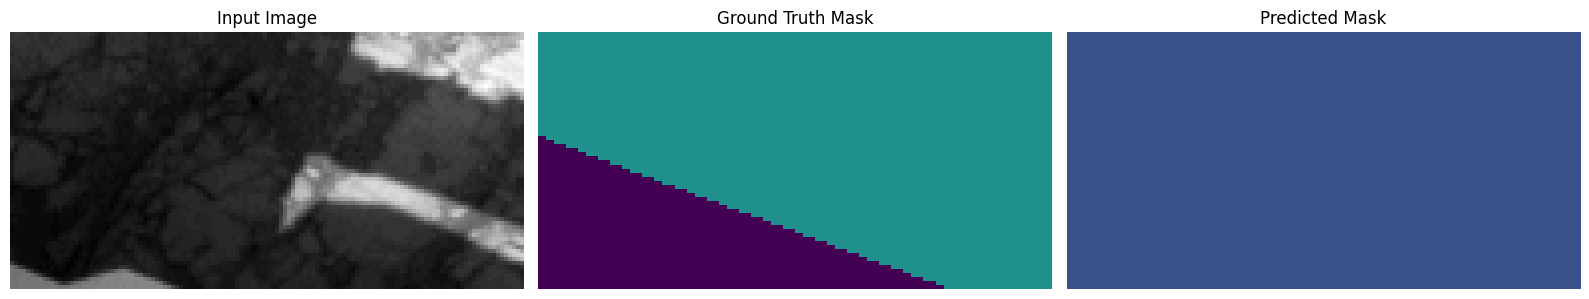

9/9 - 4s - 408ms/step - accuracy: 0.7015 - loss: 4.8226 - mean_iou: 0.5677 - val_accuracy: 0.6662 - val_loss: 4.9704 - val_mean_iou: 0.6419
Epoch 132/1000
9/9 - 3s - 377ms/step - accuracy: 0.7075 - loss: 4.8090 - mean_iou: 0.7156 - val_accuracy: 0.6608 - val_loss: 4.9867 - val_mean_iou: 0.6086
Epoch 133/1000
9/9 - 3s - 377ms/step - accuracy: 0.7039 - loss: 4.8211 - mean_iou: 0.7112 - val_accuracy: 0.6605 - val_loss: 5.0007 - val_mean_iou: 0.6062
Epoch 134/1000
9/9 - 3s - 377ms/step - accuracy: 0.6887 - loss: 4.8653 - mean_iou: 0.6684 - val_accuracy: 0.6340 - val_loss: 5.2079 - val_mean_iou: 0.4464
Epoch 135/1000
9/9 - 3s - 377ms/step - accuracy: 0.6986 - loss: 4.8410 - mean_iou: 0.6954 - val_accuracy: 0.6304 - val_loss: 5.2478 - val_mean_iou: 0.4556
Epoch 136/1000


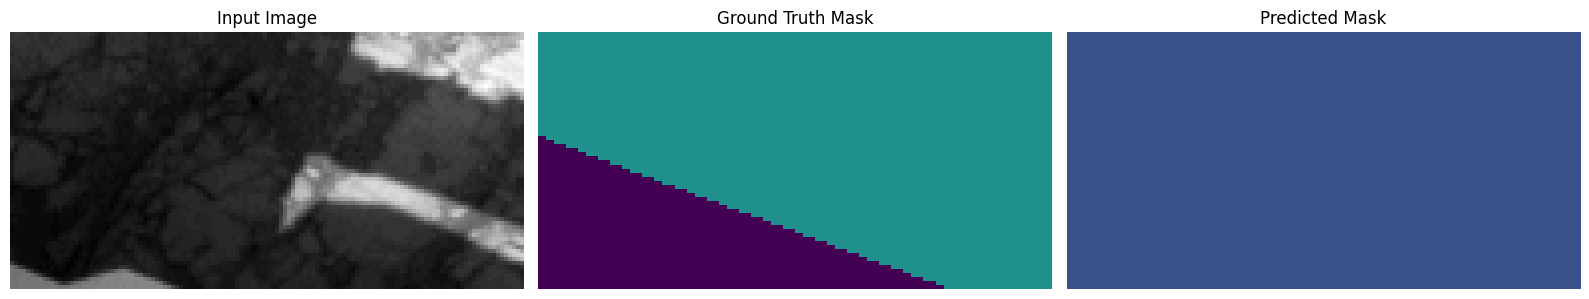

9/9 - 4s - 415ms/step - accuracy: 0.6984 - loss: 4.8310 - mean_iou: 0.5588 - val_accuracy: 0.6362 - val_loss: 5.0243 - val_mean_iou: 0.4599
Epoch 137/1000
9/9 - 3s - 378ms/step - accuracy: 0.7102 - loss: 4.8058 - mean_iou: 0.7196 - val_accuracy: 0.6664 - val_loss: 4.9752 - val_mean_iou: 0.5032
Epoch 138/1000
9/9 - 3s - 382ms/step - accuracy: 0.7074 - loss: 4.8059 - mean_iou: 0.7176 - val_accuracy: 0.7036 - val_loss: 4.8417 - val_mean_iou: 0.6956
Epoch 139/1000
9/9 - 3s - 377ms/step - accuracy: 0.7069 - loss: 4.8208 - mean_iou: 0.6989 - val_accuracy: 0.6272 - val_loss: 5.2297 - val_mean_iou: 0.6031
Epoch 140/1000
9/9 - 3s - 376ms/step - accuracy: 0.7069 - loss: 4.8046 - mean_iou: 0.7344 - val_accuracy: 0.6861 - val_loss: 4.8960 - val_mean_iou: 0.6756
Epoch 141/1000


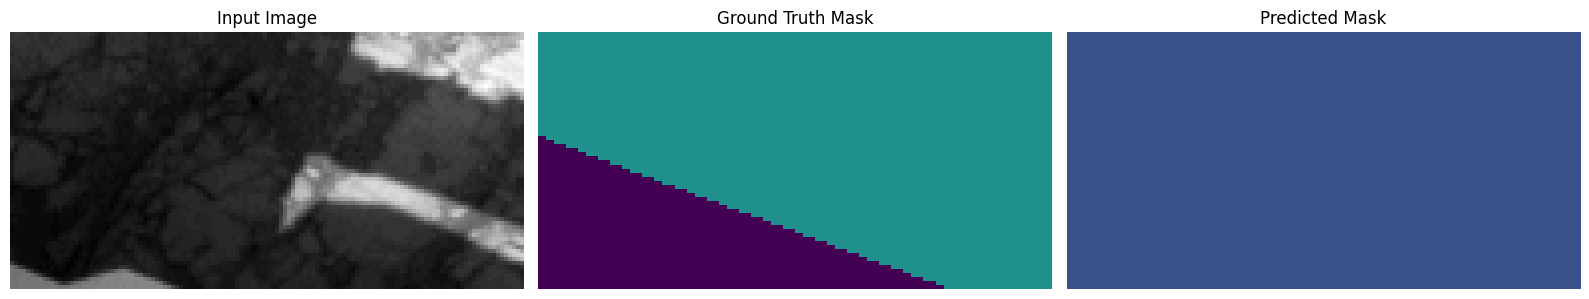

9/9 - 4s - 407ms/step - accuracy: 0.7073 - loss: 4.8165 - mean_iou: 0.7071 - val_accuracy: 0.6659 - val_loss: 4.9732 - val_mean_iou: 0.6647
Epoch 142/1000
9/9 - 3s - 377ms/step - accuracy: 0.7058 - loss: 4.8110 - mean_iou: 0.7212 - val_accuracy: 0.6343 - val_loss: 5.1703 - val_mean_iou: 0.4539
Epoch 143/1000
9/9 - 3s - 376ms/step - accuracy: 0.6959 - loss: 4.8424 - mean_iou: 0.6942 - val_accuracy: 0.6382 - val_loss: 5.0740 - val_mean_iou: 0.4791
Epoch 144/1000
9/9 - 3s - 376ms/step - accuracy: 0.6951 - loss: 4.8446 - mean_iou: 0.6988 - val_accuracy: 0.4735 - val_loss: 6.0363 - val_mean_iou: 0.3795
Epoch 145/1000
9/9 - 3s - 376ms/step - accuracy: 0.7016 - loss: 4.8152 - mean_iou: 0.7110 - val_accuracy: 0.6874 - val_loss: 4.9013 - val_mean_iou: 0.6732
Epoch 146/1000


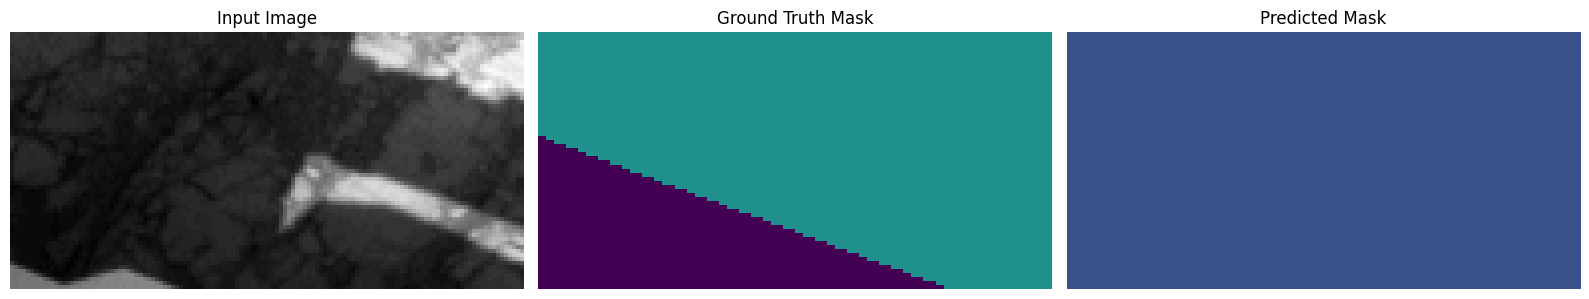

9/9 - 4s - 416ms/step - accuracy: 0.7065 - loss: 4.8079 - mean_iou: 0.7241 - val_accuracy: 0.6620 - val_loss: 4.9894 - val_mean_iou: 0.6603
Epoch 147/1000
9/9 - 3s - 376ms/step - accuracy: 0.7083 - loss: 4.8117 - mean_iou: 0.7278 - val_accuracy: 0.6612 - val_loss: 5.0478 - val_mean_iou: 0.5105
Epoch 148/1000
9/9 - 3s - 377ms/step - accuracy: 0.7046 - loss: 4.8133 - mean_iou: 0.7239 - val_accuracy: 0.6272 - val_loss: 5.1823 - val_mean_iou: 0.5820
Epoch 149/1000
9/9 - 3s - 378ms/step - accuracy: 0.7033 - loss: 4.8297 - mean_iou: 0.7137 - val_accuracy: 0.6003 - val_loss: 5.4503 - val_mean_iou: 0.5536
Epoch 150/1000
9/9 - 3s - 382ms/step - accuracy: 0.7085 - loss: 4.8002 - mean_iou: 0.7456 - val_accuracy: 0.6737 - val_loss: 4.9472 - val_mean_iou: 0.7052
Epoch 151/1000


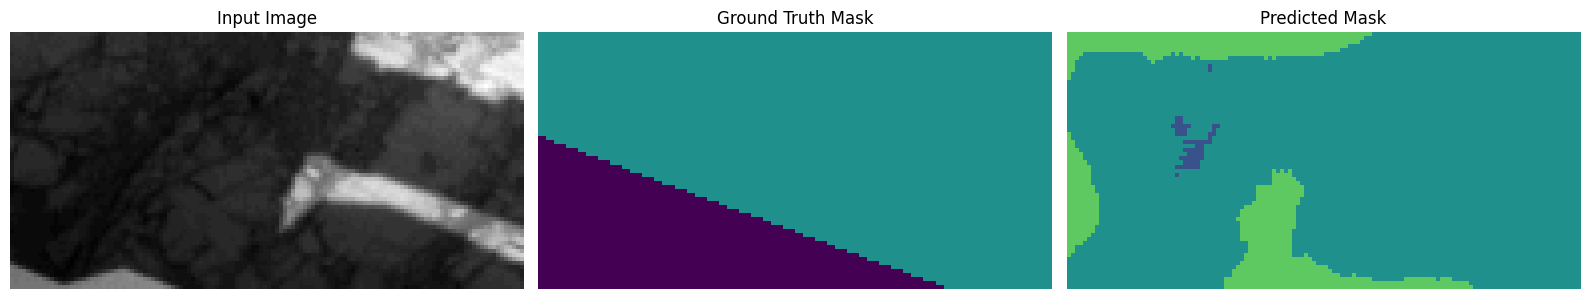

9/9 - 4s - 406ms/step - accuracy: 0.7126 - loss: 4.7783 - mean_iou: 0.7311 - val_accuracy: 0.7021 - val_loss: 4.8474 - val_mean_iou: 0.6934
Epoch 152/1000
9/9 - 3s - 377ms/step - accuracy: 0.7134 - loss: 4.7786 - mean_iou: 0.7604 - val_accuracy: 0.6877 - val_loss: 4.8639 - val_mean_iou: 0.6969
Epoch 153/1000
9/9 - 3s - 376ms/step - accuracy: 0.7084 - loss: 4.7968 - mean_iou: 0.7372 - val_accuracy: 0.6145 - val_loss: 5.1681 - val_mean_iou: 0.5216
Epoch 154/1000
9/9 - 3s - 376ms/step - accuracy: 0.7000 - loss: 4.8131 - mean_iou: 0.7250 - val_accuracy: 0.6797 - val_loss: 4.9429 - val_mean_iou: 0.6792
Epoch 155/1000
9/9 - 3s - 376ms/step - accuracy: 0.7090 - loss: 4.7998 - mean_iou: 0.7471 - val_accuracy: 0.6401 - val_loss: 5.0847 - val_mean_iou: 0.5778
Epoch 156/1000


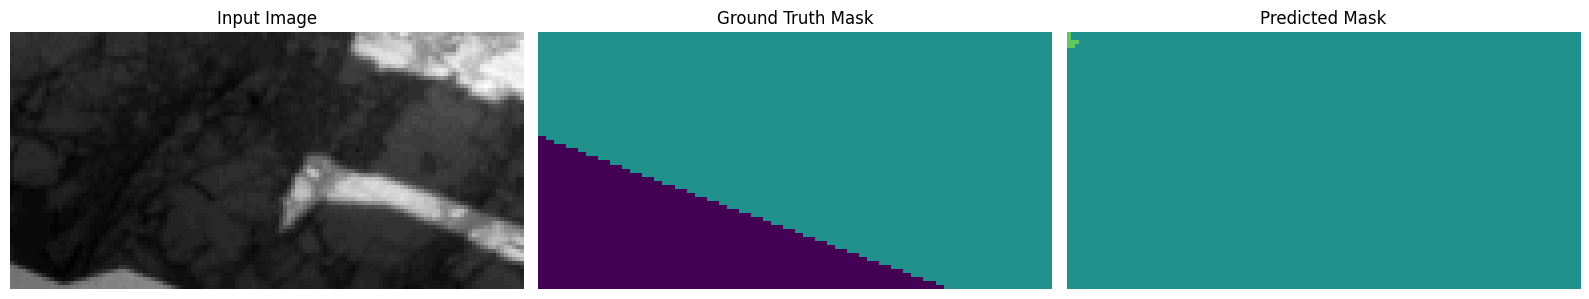

9/9 - 4s - 407ms/step - accuracy: 0.7085 - loss: 4.7893 - mean_iou: 0.7570 - val_accuracy: 0.6783 - val_loss: 4.8895 - val_mean_iou: 0.6875
Epoch 157/1000
9/9 - 3s - 377ms/step - accuracy: 0.7090 - loss: 4.7956 - mean_iou: 0.7422 - val_accuracy: 0.6729 - val_loss: 4.9333 - val_mean_iou: 0.6825
Epoch 158/1000
9/9 - 3s - 377ms/step - accuracy: 0.7124 - loss: 4.7928 - mean_iou: 0.7452 - val_accuracy: 0.6200 - val_loss: 5.2900 - val_mean_iou: 0.5950
Epoch 159/1000
9/9 - 3s - 377ms/step - accuracy: 0.7152 - loss: 4.7774 - mean_iou: 0.7647 - val_accuracy: 0.6569 - val_loss: 4.9626 - val_mean_iou: 0.6773
Epoch 160/1000
9/9 - 3s - 377ms/step - accuracy: 0.7133 - loss: 4.7872 - mean_iou: 0.7458 - val_accuracy: 0.6907 - val_loss: 4.8693 - val_mean_iou: 0.7018
Epoch 161/1000


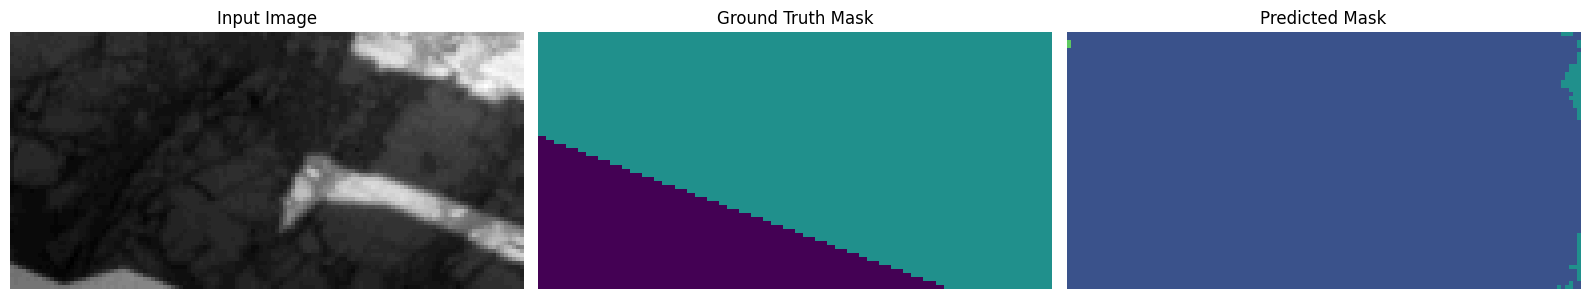

9/9 - 4s - 419ms/step - accuracy: 0.7103 - loss: 4.8065 - mean_iou: 0.7455 - val_accuracy: 0.6829 - val_loss: 4.8737 - val_mean_iou: 0.7131
Epoch 162/1000
9/9 - 3s - 378ms/step - accuracy: 0.7110 - loss: 4.7987 - mean_iou: 0.7380 - val_accuracy: 0.6406 - val_loss: 5.1373 - val_mean_iou: 0.5997
Epoch 163/1000
9/9 - 3s - 377ms/step - accuracy: 0.7063 - loss: 4.8203 - mean_iou: 0.7057 - val_accuracy: 0.6079 - val_loss: 5.2711 - val_mean_iou: 0.5411
Epoch 164/1000
9/9 - 3s - 377ms/step - accuracy: 0.7104 - loss: 4.7994 - mean_iou: 0.7284 - val_accuracy: 0.6644 - val_loss: 5.0319 - val_mean_iou: 0.6653
Epoch 165/1000
9/9 - 3s - 376ms/step - accuracy: 0.6993 - loss: 4.8176 - mean_iou: 0.7082 - val_accuracy: 0.6471 - val_loss: 4.9907 - val_mean_iou: 0.6419
Epoch 166/1000


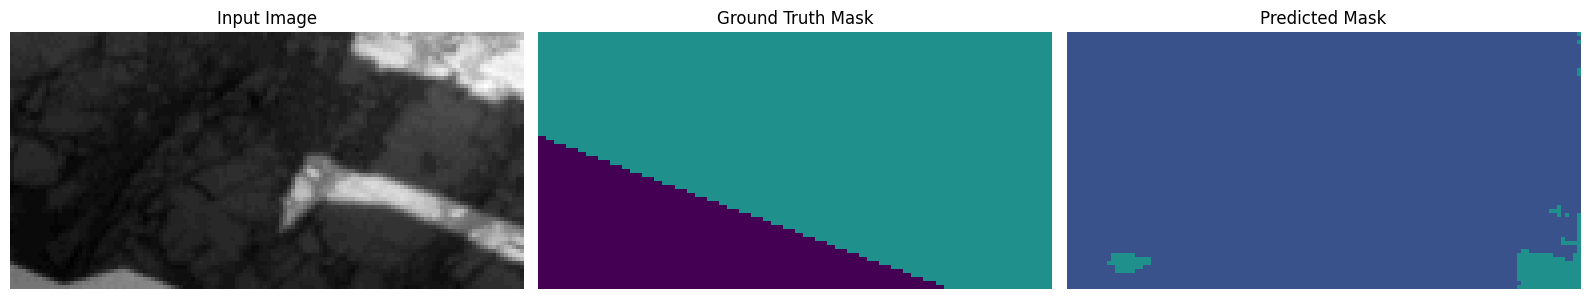

9/9 - 4s - 417ms/step - accuracy: 0.7085 - loss: 4.7984 - mean_iou: 0.7432 - val_accuracy: 0.6432 - val_loss: 5.0748 - val_mean_iou: 0.5929
Epoch 167/1000
9/9 - 3s - 376ms/step - accuracy: 0.7092 - loss: 4.7920 - mean_iou: 0.7474 - val_accuracy: 0.6857 - val_loss: 4.9208 - val_mean_iou: 0.6948
Epoch 168/1000
9/9 - 3s - 382ms/step - accuracy: 0.7154 - loss: 4.7763 - mean_iou: 0.7685 - val_accuracy: 0.7091 - val_loss: 4.8308 - val_mean_iou: 0.7618
Epoch 169/1000
9/9 - 3s - 376ms/step - accuracy: 0.7166 - loss: 4.7845 - mean_iou: 0.7806 - val_accuracy: 0.6611 - val_loss: 5.0638 - val_mean_iou: 0.6118
Epoch 170/1000
9/9 - 3s - 376ms/step - accuracy: 0.7136 - loss: 4.7725 - mean_iou: 0.7757 - val_accuracy: 0.6568 - val_loss: 5.0146 - val_mean_iou: 0.6596
Epoch 171/1000


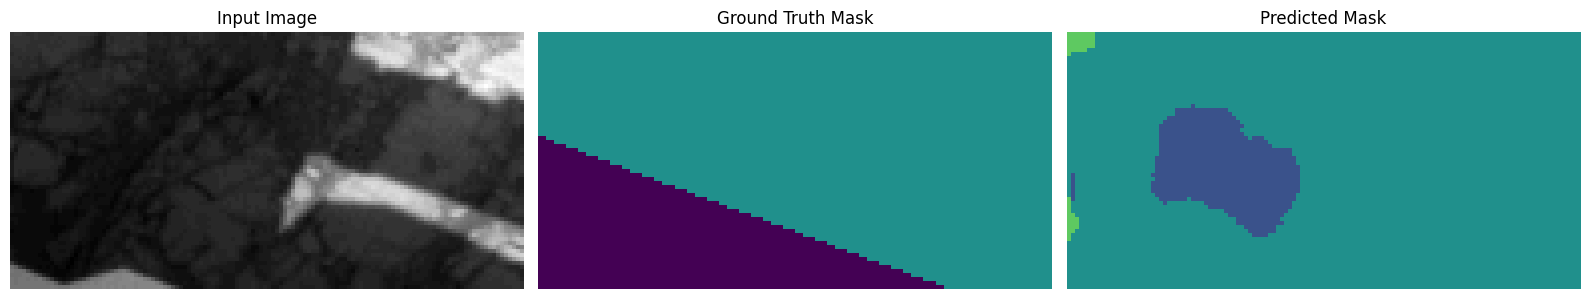

9/9 - 4s - 416ms/step - accuracy: 0.7133 - loss: 4.7774 - mean_iou: 0.7685 - val_accuracy: 0.6927 - val_loss: 4.8672 - val_mean_iou: 0.7259
Epoch 172/1000
9/9 - 3s - 377ms/step - accuracy: 0.7136 - loss: 4.7843 - mean_iou: 0.7657 - val_accuracy: 0.7080 - val_loss: 4.8235 - val_mean_iou: 0.6915
Epoch 173/1000
9/9 - 3s - 383ms/step - accuracy: 0.7150 - loss: 4.7866 - mean_iou: 0.7418 - val_accuracy: 0.7167 - val_loss: 4.7823 - val_mean_iou: 0.7862
Epoch 174/1000
9/9 - 3s - 376ms/step - accuracy: 0.7180 - loss: 4.7770 - mean_iou: 0.7614 - val_accuracy: 0.5726 - val_loss: 5.6841 - val_mean_iou: 0.5440
Epoch 175/1000
9/9 - 3s - 376ms/step - accuracy: 0.7095 - loss: 4.7944 - mean_iou: 0.7601 - val_accuracy: 0.6890 - val_loss: 4.9236 - val_mean_iou: 0.7216
Epoch 176/1000


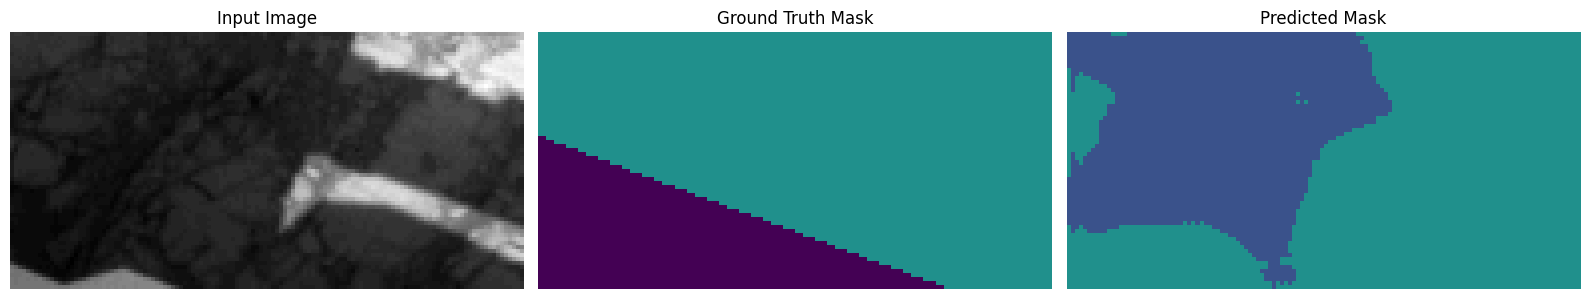

9/9 - 4s - 417ms/step - accuracy: 0.7141 - loss: 4.7677 - mean_iou: 0.7756 - val_accuracy: 0.6982 - val_loss: 4.8353 - val_mean_iou: 0.7498
Epoch 177/1000
9/9 - 3s - 381ms/step - accuracy: 0.7177 - loss: 4.7618 - mean_iou: 0.7877 - val_accuracy: 0.7165 - val_loss: 4.7753 - val_mean_iou: 0.7947
Epoch 178/1000
9/9 - 3s - 376ms/step - accuracy: 0.7186 - loss: 4.7789 - mean_iou: 0.7754 - val_accuracy: 0.7182 - val_loss: 4.7864 - val_mean_iou: 0.7492
Epoch 179/1000
9/9 - 3s - 377ms/step - accuracy: 0.7153 - loss: 4.7789 - mean_iou: 0.7553 - val_accuracy: 0.7080 - val_loss: 4.8220 - val_mean_iou: 0.7495
Epoch 180/1000
9/9 - 3s - 376ms/step - accuracy: 0.7157 - loss: 4.7773 - mean_iou: 0.7802 - val_accuracy: 0.6706 - val_loss: 4.9615 - val_mean_iou: 0.6756
Epoch 181/1000


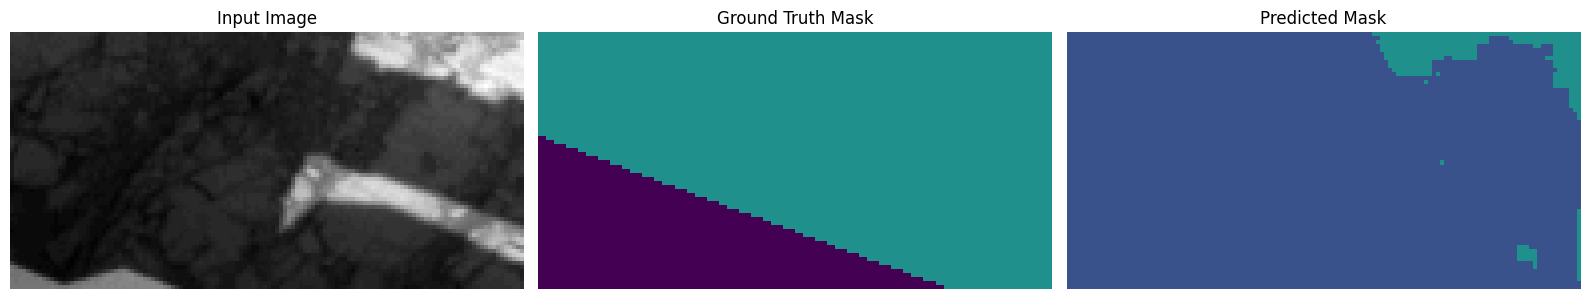

9/9 - 4s - 406ms/step - accuracy: 0.7186 - loss: 4.7569 - mean_iou: 0.7870 - val_accuracy: 0.6972 - val_loss: 4.8496 - val_mean_iou: 0.7334
Epoch 182/1000
9/9 - 3s - 377ms/step - accuracy: 0.7200 - loss: 4.7662 - mean_iou: 0.7785 - val_accuracy: 0.6945 - val_loss: 4.8508 - val_mean_iou: 0.7387
Epoch 183/1000
9/9 - 3s - 377ms/step - accuracy: 0.7179 - loss: 4.7793 - mean_iou: 0.7783 - val_accuracy: 0.6973 - val_loss: 4.8322 - val_mean_iou: 0.7447
Epoch 184/1000
9/9 - 3s - 376ms/step - accuracy: 0.7203 - loss: 4.7586 - mean_iou: 0.7946 - val_accuracy: 0.6604 - val_loss: 4.9206 - val_mean_iou: 0.6759
Epoch 185/1000
9/9 - 3s - 382ms/step - accuracy: 0.7235 - loss: 4.7614 - mean_iou: 0.7924 - val_accuracy: 0.7237 - val_loss: 4.7516 - val_mean_iou: 0.7964
Epoch 186/1000


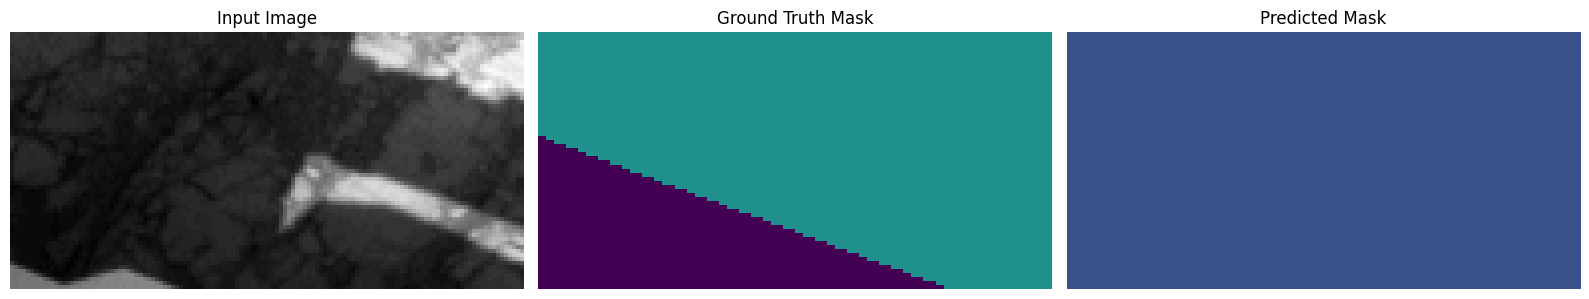

9/9 - 4s - 408ms/step - accuracy: 0.7195 - loss: 4.7500 - mean_iou: 0.8039 - val_accuracy: 0.6809 - val_loss: 4.9357 - val_mean_iou: 0.6938
Epoch 187/1000
9/9 - 3s - 376ms/step - accuracy: 0.7175 - loss: 4.7794 - mean_iou: 0.7450 - val_accuracy: 0.7049 - val_loss: 4.8354 - val_mean_iou: 0.7234
Epoch 188/1000
9/9 - 3s - 376ms/step - accuracy: 0.7132 - loss: 4.7895 - mean_iou: 0.7501 - val_accuracy: 0.6436 - val_loss: 5.0572 - val_mean_iou: 0.6041
Epoch 189/1000
9/9 - 3s - 376ms/step - accuracy: 0.7151 - loss: 4.7880 - mean_iou: 0.7457 - val_accuracy: 0.6708 - val_loss: 4.9702 - val_mean_iou: 0.6475
Epoch 190/1000
9/9 - 3s - 377ms/step - accuracy: 0.7049 - loss: 4.8206 - mean_iou: 0.7334 - val_accuracy: 0.6373 - val_loss: 5.1166 - val_mean_iou: 0.5872
Epoch 191/1000


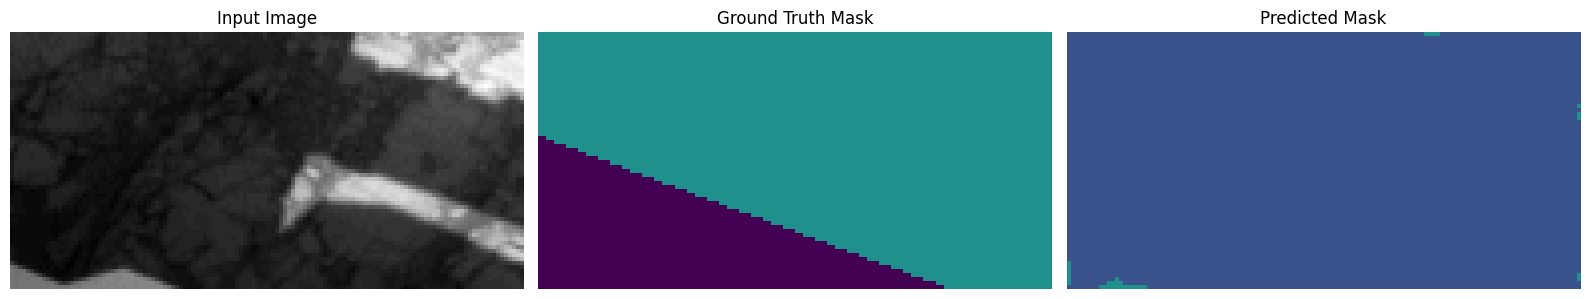

9/9 - 4s - 407ms/step - accuracy: 0.7139 - loss: 4.7804 - mean_iou: 0.7713 - val_accuracy: 0.6162 - val_loss: 5.0431 - val_mean_iou: 0.5859
Epoch 192/1000
9/9 - 3s - 376ms/step - accuracy: 0.7201 - loss: 4.7619 - mean_iou: 0.7762 - val_accuracy: 0.6837 - val_loss: 4.8944 - val_mean_iou: 0.7270
Epoch 193/1000
9/9 - 3s - 376ms/step - accuracy: 0.7188 - loss: 4.7586 - mean_iou: 0.7780 - val_accuracy: 0.6996 - val_loss: 4.8427 - val_mean_iou: 0.7578
Epoch 194/1000
9/9 - 3s - 378ms/step - accuracy: 0.7203 - loss: 4.7494 - mean_iou: 0.7897 - val_accuracy: 0.7055 - val_loss: 4.8162 - val_mean_iou: 0.7694
Epoch 195/1000
9/9 - 3s - 383ms/step - accuracy: 0.7196 - loss: 4.7663 - mean_iou: 0.7836 - val_accuracy: 0.7221 - val_loss: 4.7619 - val_mean_iou: 0.8005
Epoch 196/1000


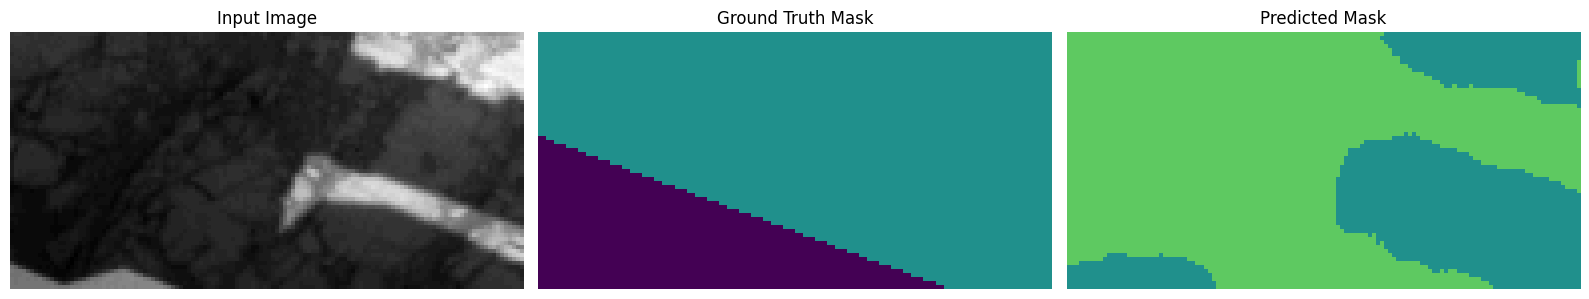

9/9 - 4s - 452ms/step - accuracy: 0.7176 - loss: 4.7540 - mean_iou: 0.7970 - val_accuracy: 0.6798 - val_loss: 4.9162 - val_mean_iou: 0.7140
Epoch 197/1000
9/9 - 3s - 377ms/step - accuracy: 0.7215 - loss: 4.7674 - mean_iou: 0.7655 - val_accuracy: 0.6401 - val_loss: 5.1415 - val_mean_iou: 0.6621
Epoch 198/1000
9/9 - 3s - 377ms/step - accuracy: 0.7237 - loss: 4.7579 - mean_iou: 0.7979 - val_accuracy: 0.7120 - val_loss: 4.8086 - val_mean_iou: 0.7806
Epoch 199/1000
9/9 - 3s - 376ms/step - accuracy: 0.7157 - loss: 4.7642 - mean_iou: 0.7920 - val_accuracy: 0.7012 - val_loss: 4.8260 - val_mean_iou: 0.7675
Epoch 200/1000
9/9 - 3s - 377ms/step - accuracy: 0.7121 - loss: 4.7671 - mean_iou: 0.7919 - val_accuracy: 0.6343 - val_loss: 5.1645 - val_mean_iou: 0.6340
Epoch 201/1000


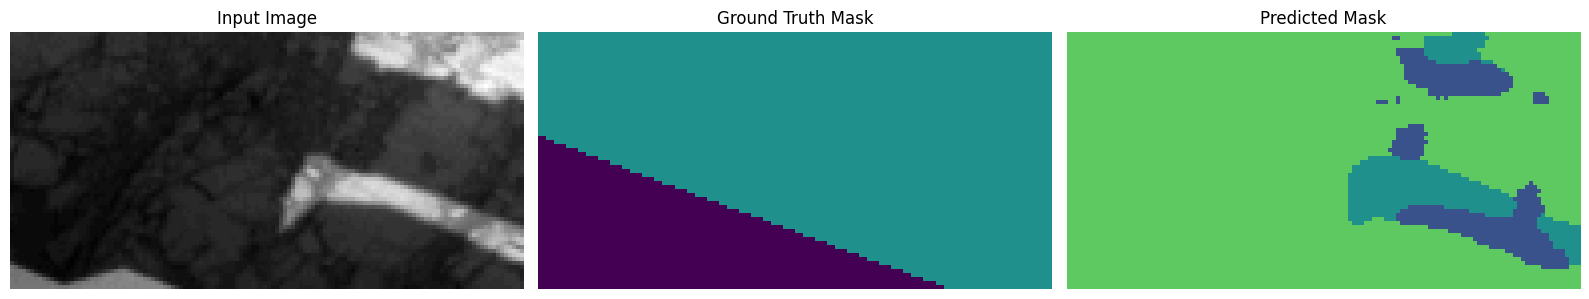

9/9 - 4s - 407ms/step - accuracy: 0.7158 - loss: 4.7701 - mean_iou: 0.7811 - val_accuracy: 0.6457 - val_loss: 5.1323 - val_mean_iou: 0.6742
Epoch 202/1000
9/9 - 3s - 376ms/step - accuracy: 0.7198 - loss: 4.7619 - mean_iou: 0.8011 - val_accuracy: 0.6426 - val_loss: 5.0693 - val_mean_iou: 0.6737
Epoch 203/1000
9/9 - 3s - 378ms/step - accuracy: 0.7230 - loss: 4.7412 - mean_iou: 0.8056 - val_accuracy: 0.7080 - val_loss: 4.8075 - val_mean_iou: 0.7918
Epoch 204/1000
9/9 - 3s - 378ms/step - accuracy: 0.7172 - loss: 4.7645 - mean_iou: 0.8009 - val_accuracy: 0.6350 - val_loss: 5.1437 - val_mean_iou: 0.6362
Epoch 205/1000
9/9 - 3s - 376ms/step - accuracy: 0.7219 - loss: 4.7453 - mean_iou: 0.8006 - val_accuracy: 0.6733 - val_loss: 4.9701 - val_mean_iou: 0.7037
Epoch 206/1000


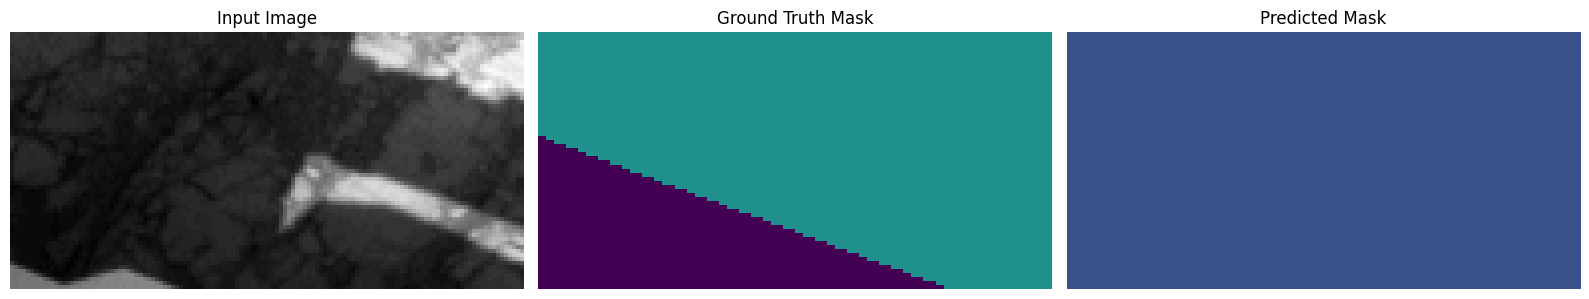

9/9 - 4s - 416ms/step - accuracy: 0.7209 - loss: 4.7615 - mean_iou: 0.7825 - val_accuracy: 0.6996 - val_loss: 4.8439 - val_mean_iou: 0.7241
Epoch 207/1000
9/9 - 3s - 377ms/step - accuracy: 0.7197 - loss: 4.7581 - mean_iou: 0.7674 - val_accuracy: 0.6905 - val_loss: 4.8652 - val_mean_iou: 0.7430
Epoch 208/1000
9/9 - 3s - 376ms/step - accuracy: 0.7213 - loss: 4.7468 - mean_iou: 0.7988 - val_accuracy: 0.7068 - val_loss: 4.8345 - val_mean_iou: 0.7840
Epoch 209/1000
9/9 - 3s - 377ms/step - accuracy: 0.7163 - loss: 4.7468 - mean_iou: 0.8085 - val_accuracy: 0.7065 - val_loss: 4.8250 - val_mean_iou: 0.7320
Epoch 210/1000
9/9 - 3s - 377ms/step - accuracy: 0.7245 - loss: 4.7435 - mean_iou: 0.8164 - val_accuracy: 0.7078 - val_loss: 4.8285 - val_mean_iou: 0.7042
Epoch 211/1000


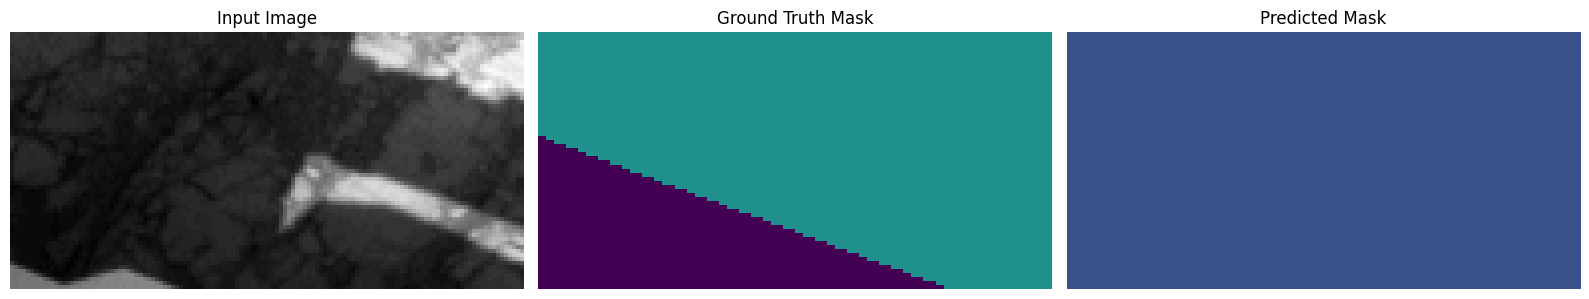

9/9 - 4s - 415ms/step - accuracy: 0.7197 - loss: 4.7536 - mean_iou: 0.7909 - val_accuracy: 0.6676 - val_loss: 4.9362 - val_mean_iou: 0.6972
Epoch 212/1000
9/9 - 3s - 377ms/step - accuracy: 0.7253 - loss: 4.7479 - mean_iou: 0.8018 - val_accuracy: 0.6798 - val_loss: 4.8849 - val_mean_iou: 0.7182
Epoch 213/1000
9/9 - 3s - 378ms/step - accuracy: 0.7237 - loss: 4.7520 - mean_iou: 0.8026 - val_accuracy: 0.6852 - val_loss: 4.8892 - val_mean_iou: 0.7360
Epoch 214/1000
9/9 - 3s - 376ms/step - accuracy: 0.7248 - loss: 4.7346 - mean_iou: 0.8130 - val_accuracy: 0.6881 - val_loss: 4.8607 - val_mean_iou: 0.7430
Epoch 215/1000
9/9 - 3s - 377ms/step - accuracy: 0.7228 - loss: 4.7424 - mean_iou: 0.8219 - val_accuracy: 0.6761 - val_loss: 4.8875 - val_mean_iou: 0.7290
Epoch 216/1000


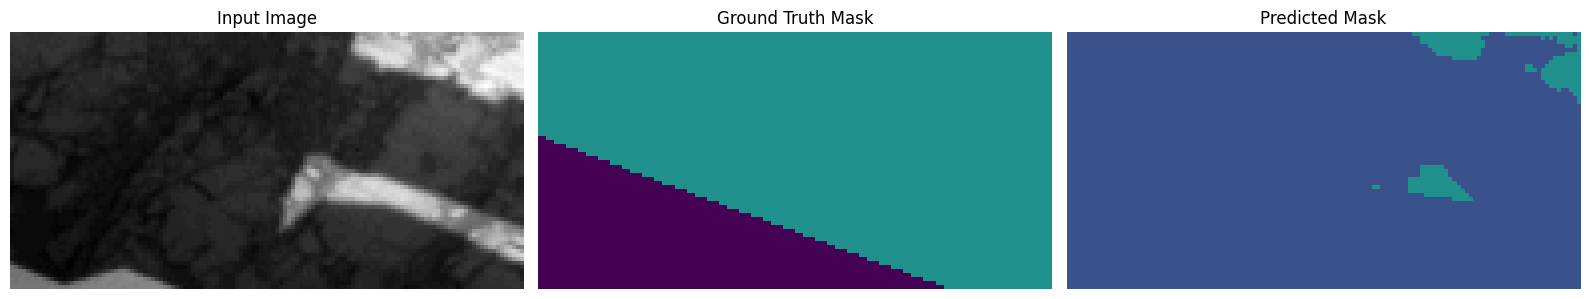

9/9 - 4s - 416ms/step - accuracy: 0.7219 - loss: 4.7473 - mean_iou: 0.8117 - val_accuracy: 0.7012 - val_loss: 4.8380 - val_mean_iou: 0.7146
Epoch 217/1000
9/9 - 3s - 377ms/step - accuracy: 0.7217 - loss: 4.7402 - mean_iou: 0.8084 - val_accuracy: 0.6438 - val_loss: 5.1111 - val_mean_iou: 0.6287
Epoch 218/1000
9/9 - 3s - 378ms/step - accuracy: 0.7203 - loss: 4.7774 - mean_iou: 0.7703 - val_accuracy: 0.7181 - val_loss: 4.7759 - val_mean_iou: 0.7757
Epoch 219/1000
9/9 - 3s - 377ms/step - accuracy: 0.7225 - loss: 4.7505 - mean_iou: 0.8006 - val_accuracy: 0.6944 - val_loss: 4.8327 - val_mean_iou: 0.7704
Epoch 220/1000
9/9 - 3s - 376ms/step - accuracy: 0.7238 - loss: 4.7489 - mean_iou: 0.7902 - val_accuracy: 0.7029 - val_loss: 4.8214 - val_mean_iou: 0.7650
Epoch 221/1000


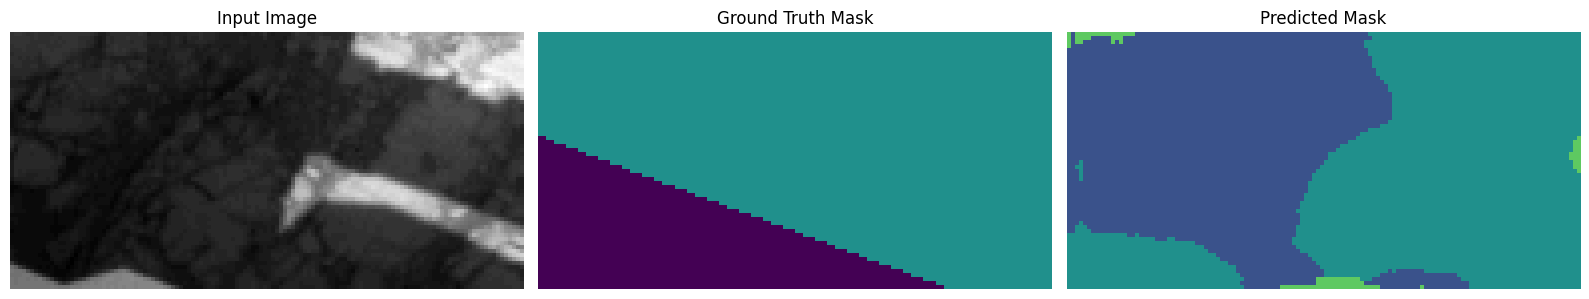

9/9 - 4s - 415ms/step - accuracy: 0.7225 - loss: 4.7447 - mean_iou: 0.7939 - val_accuracy: 0.7124 - val_loss: 4.7901 - val_mean_iou: 0.7765
Epoch 222/1000
9/9 - 3s - 377ms/step - accuracy: 0.7200 - loss: 4.7599 - mean_iou: 0.7819 - val_accuracy: 0.7016 - val_loss: 4.8254 - val_mean_iou: 0.7775
Epoch 223/1000
9/9 - 3s - 376ms/step - accuracy: 0.7191 - loss: 4.7478 - mean_iou: 0.7945 - val_accuracy: 0.6976 - val_loss: 4.8802 - val_mean_iou: 0.6843
Epoch 224/1000
9/9 - 3s - 376ms/step - accuracy: 0.7208 - loss: 4.7476 - mean_iou: 0.8018 - val_accuracy: 0.6741 - val_loss: 4.9244 - val_mean_iou: 0.6852
Epoch 225/1000
9/9 - 3s - 377ms/step - accuracy: 0.7253 - loss: 4.7573 - mean_iou: 0.7937 - val_accuracy: 0.6626 - val_loss: 5.0509 - val_mean_iou: 0.6357
Epoch 226/1000


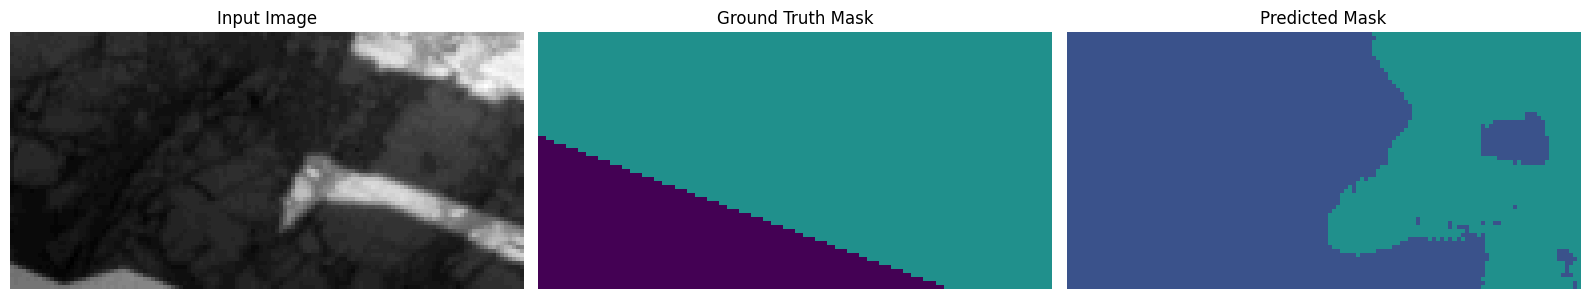

9/9 - 4s - 406ms/step - accuracy: 0.7244 - loss: 4.7429 - mean_iou: 0.8190 - val_accuracy: 0.7124 - val_loss: 4.7961 - val_mean_iou: 0.7597
Epoch 227/1000
9/9 - 3s - 382ms/step - accuracy: 0.7181 - loss: 4.7499 - mean_iou: 0.7974 - val_accuracy: 0.7126 - val_loss: 4.7747 - val_mean_iou: 0.8033
Epoch 228/1000
9/9 - 3s - 379ms/step - accuracy: 0.7158 - loss: 4.7784 - mean_iou: 0.7773 - val_accuracy: 0.5943 - val_loss: 5.4321 - val_mean_iou: 0.5400
Epoch 229/1000
9/9 - 3s - 376ms/step - accuracy: 0.7177 - loss: 4.7607 - mean_iou: 0.7916 - val_accuracy: 0.7020 - val_loss: 4.8296 - val_mean_iou: 0.7286
Epoch 230/1000
9/9 - 3s - 377ms/step - accuracy: 0.7231 - loss: 4.7421 - mean_iou: 0.8114 - val_accuracy: 0.7103 - val_loss: 4.7770 - val_mean_iou: 0.7959
Epoch 231/1000


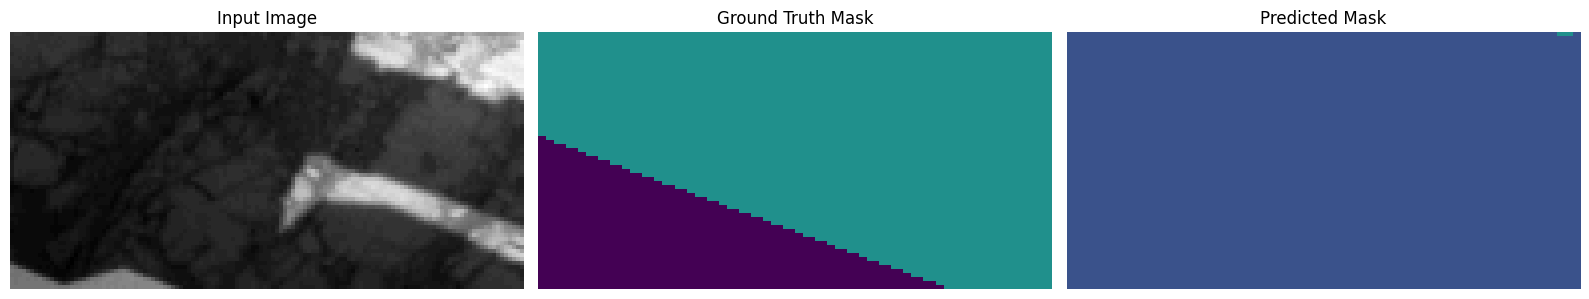

9/9 - 4s - 415ms/step - accuracy: 0.7203 - loss: 4.7514 - mean_iou: 0.7789 - val_accuracy: 0.6886 - val_loss: 4.8705 - val_mean_iou: 0.7396
Epoch 232/1000
9/9 - 3s - 376ms/step - accuracy: 0.7198 - loss: 4.7593 - mean_iou: 0.7876 - val_accuracy: 0.6873 - val_loss: 4.8805 - val_mean_iou: 0.7265
Epoch 233/1000
9/9 - 3s - 376ms/step - accuracy: 0.7217 - loss: 4.7370 - mean_iou: 0.8252 - val_accuracy: 0.6828 - val_loss: 4.9091 - val_mean_iou: 0.7325
Epoch 234/1000
9/9 - 3s - 376ms/step - accuracy: 0.7259 - loss: 4.7280 - mean_iou: 0.8363 - val_accuracy: 0.7094 - val_loss: 4.8042 - val_mean_iou: 0.7506
Epoch 235/1000
9/9 - 3s - 377ms/step - accuracy: 0.7208 - loss: 4.7389 - mean_iou: 0.8261 - val_accuracy: 0.6895 - val_loss: 4.8712 - val_mean_iou: 0.7605
Epoch 236/1000


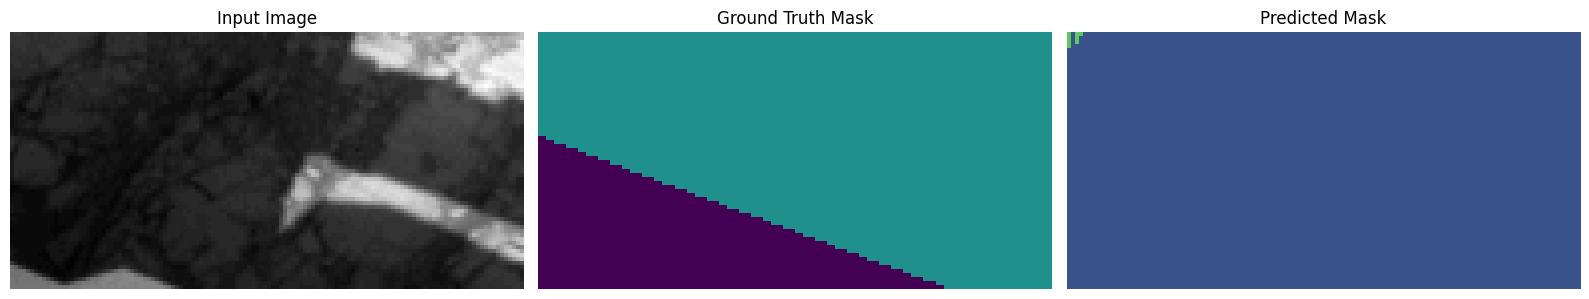

9/9 - 4s - 421ms/step - accuracy: 0.7236 - loss: 4.7351 - mean_iou: 0.8128 - val_accuracy: 0.7130 - val_loss: 4.7584 - val_mean_iou: 0.8123
Epoch 237/1000
9/9 - 3s - 376ms/step - accuracy: 0.7279 - loss: 4.7284 - mean_iou: 0.8306 - val_accuracy: 0.7089 - val_loss: 4.8089 - val_mean_iou: 0.8103
Epoch 238/1000
9/9 - 3s - 376ms/step - accuracy: 0.7246 - loss: 4.7245 - mean_iou: 0.8280 - val_accuracy: 0.7123 - val_loss: 4.7727 - val_mean_iou: 0.8115
Epoch 239/1000
9/9 - 3s - 376ms/step - accuracy: 0.7299 - loss: 4.7178 - mean_iou: 0.8409 - val_accuracy: 0.7126 - val_loss: 4.7811 - val_mean_iou: 0.8032
Epoch 240/1000
9/9 - 3s - 377ms/step - accuracy: 0.7242 - loss: 4.7251 - mean_iou: 0.8368 - val_accuracy: 0.7183 - val_loss: 4.7679 - val_mean_iou: 0.7765
Epoch 241/1000


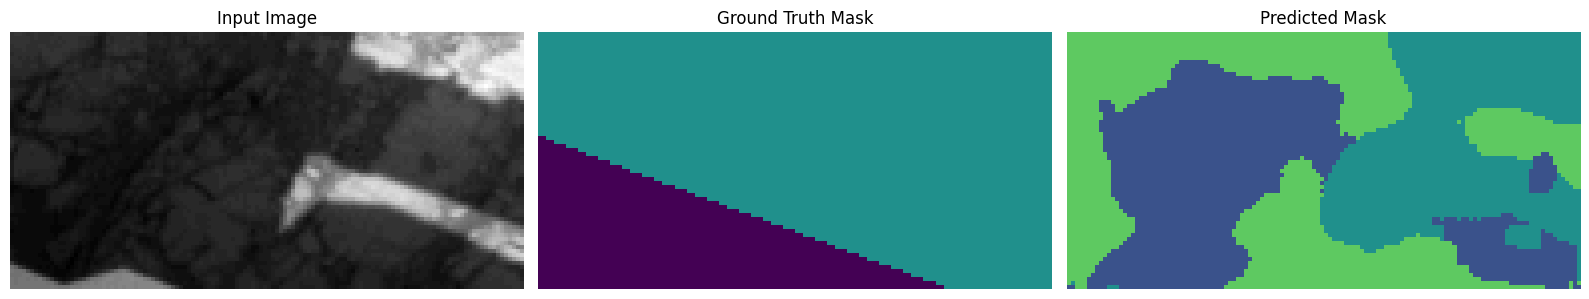

9/9 - 4s - 421ms/step - accuracy: 0.7249 - loss: 4.7360 - mean_iou: 0.8179 - val_accuracy: 0.7145 - val_loss: 4.7586 - val_mean_iou: 0.8238
Epoch 242/1000
9/9 - 3s - 381ms/step - accuracy: 0.7263 - loss: 4.7277 - mean_iou: 0.8351 - val_accuracy: 0.7168 - val_loss: 4.7622 - val_mean_iou: 0.8335
Epoch 243/1000
9/9 - 3s - 377ms/step - accuracy: 0.7264 - loss: 4.7362 - mean_iou: 0.8177 - val_accuracy: 0.7185 - val_loss: 4.7513 - val_mean_iou: 0.8134
Epoch 244/1000
9/9 - 3s - 382ms/step - accuracy: 0.7294 - loss: 4.7192 - mean_iou: 0.8504 - val_accuracy: 0.7291 - val_loss: 4.7211 - val_mean_iou: 0.8561
Epoch 245/1000
9/9 - 3s - 382ms/step - accuracy: 0.7305 - loss: 4.7081 - mean_iou: 0.8516 - val_accuracy: 0.7312 - val_loss: 4.7094 - val_mean_iou: 0.8627
Epoch 246/1000


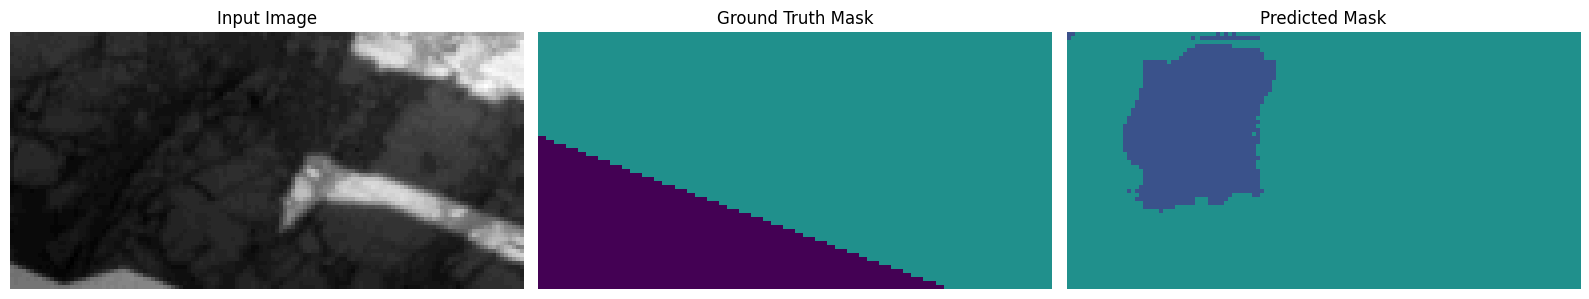

9/9 - 4s - 411ms/step - accuracy: 0.7318 - loss: 4.7074 - mean_iou: 0.8557 - val_accuracy: 0.7341 - val_loss: 4.7048 - val_mean_iou: 0.8630
Epoch 247/1000
9/9 - 3s - 376ms/step - accuracy: 0.7345 - loss: 4.7073 - mean_iou: 0.8572 - val_accuracy: 0.7288 - val_loss: 4.7193 - val_mean_iou: 0.8590
Epoch 248/1000
9/9 - 3s - 376ms/step - accuracy: 0.7311 - loss: 4.7163 - mean_iou: 0.8491 - val_accuracy: 0.7321 - val_loss: 4.7058 - val_mean_iou: 0.8627
Epoch 249/1000
9/9 - 3s - 377ms/step - accuracy: 0.7282 - loss: 4.7300 - mean_iou: 0.8267 - val_accuracy: 0.6943 - val_loss: 4.8641 - val_mean_iou: 0.7697
Epoch 250/1000
9/9 - 3s - 376ms/step - accuracy: 0.7225 - loss: 4.7314 - mean_iou: 0.8371 - val_accuracy: 0.7222 - val_loss: 4.7329 - val_mean_iou: 0.8365
Epoch 251/1000


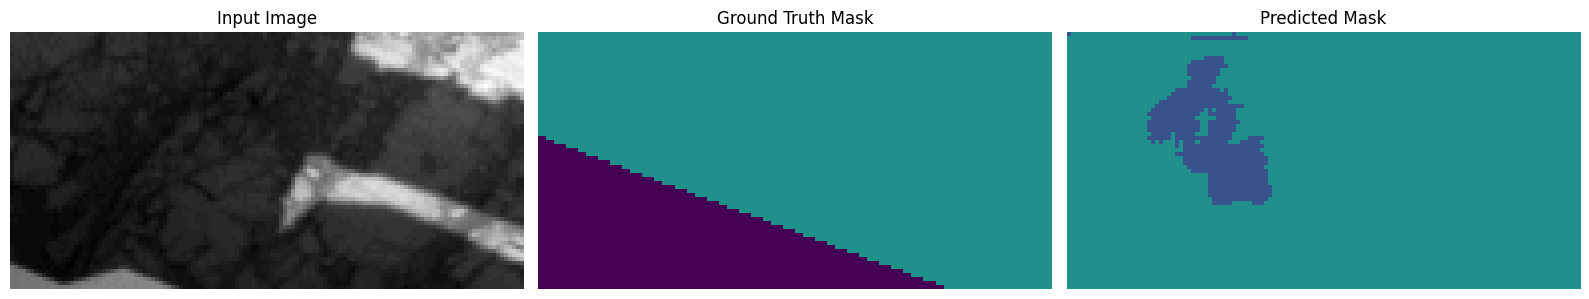

9/9 - 4s - 406ms/step - accuracy: 0.7289 - loss: 4.7273 - mean_iou: 0.8426 - val_accuracy: 0.6897 - val_loss: 4.8461 - val_mean_iou: 0.7863
Epoch 252/1000
9/9 - 3s - 376ms/step - accuracy: 0.7293 - loss: 4.7126 - mean_iou: 0.8354 - val_accuracy: 0.7166 - val_loss: 4.7671 - val_mean_iou: 0.8156
Epoch 253/1000
9/9 - 3s - 377ms/step - accuracy: 0.7255 - loss: 4.7351 - mean_iou: 0.8094 - val_accuracy: 0.6867 - val_loss: 4.9055 - val_mean_iou: 0.7477
Epoch 254/1000
9/9 - 3s - 377ms/step - accuracy: 0.7285 - loss: 4.7255 - mean_iou: 0.8306 - val_accuracy: 0.6896 - val_loss: 4.8527 - val_mean_iou: 0.7705
Epoch 255/1000
9/9 - 3s - 377ms/step - accuracy: 0.7293 - loss: 4.7174 - mean_iou: 0.8379 - val_accuracy: 0.7130 - val_loss: 4.7731 - val_mean_iou: 0.8186
Epoch 256/1000


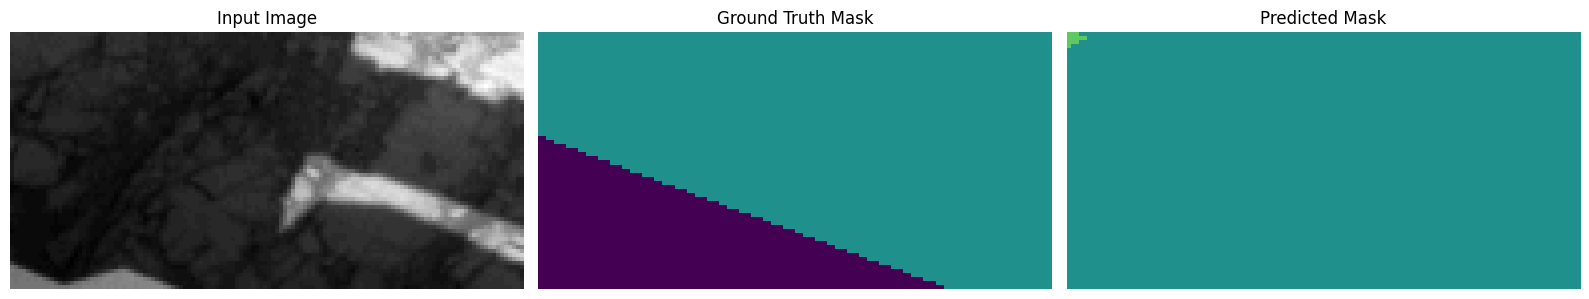

9/9 - 4s - 407ms/step - accuracy: 0.7305 - loss: 4.7174 - mean_iou: 0.8486 - val_accuracy: 0.6846 - val_loss: 4.8514 - val_mean_iou: 0.7494
Epoch 257/1000
9/9 - 3s - 377ms/step - accuracy: 0.7324 - loss: 4.7120 - mean_iou: 0.8599 - val_accuracy: 0.6521 - val_loss: 5.0330 - val_mean_iou: 0.7083
Epoch 258/1000
9/9 - 3s - 378ms/step - accuracy: 0.7315 - loss: 4.7148 - mean_iou: 0.8607 - val_accuracy: 0.7248 - val_loss: 4.7300 - val_mean_iou: 0.8487
Epoch 259/1000
9/9 - 3s - 379ms/step - accuracy: 0.7275 - loss: 4.7195 - mean_iou: 0.8460 - val_accuracy: 0.7032 - val_loss: 4.8032 - val_mean_iou: 0.7954
Epoch 260/1000
9/9 - 3s - 377ms/step - accuracy: 0.7190 - loss: 4.7645 - mean_iou: 0.7925 - val_accuracy: 0.5184 - val_loss: 6.1340 - val_mean_iou: 0.4576
Epoch 261/1000


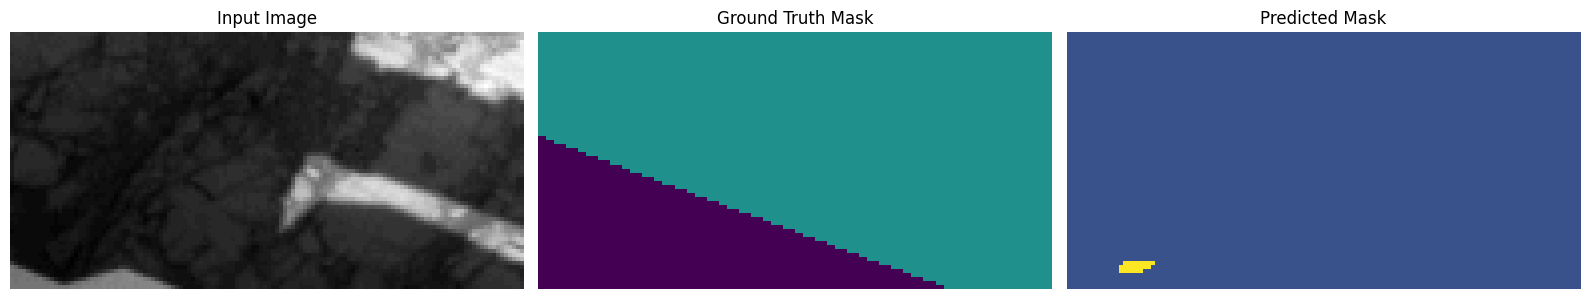

9/9 - 4s - 417ms/step - accuracy: 0.7134 - loss: 4.7712 - mean_iou: 0.7686 - val_accuracy: 0.6163 - val_loss: 5.1807 - val_mean_iou: 0.5469
Epoch 262/1000
9/9 - 3s - 376ms/step - accuracy: 0.7073 - loss: 4.8004 - mean_iou: 0.7557 - val_accuracy: 0.5873 - val_loss: 5.3407 - val_mean_iou: 0.4786
Epoch 263/1000
9/9 - 3s - 377ms/step - accuracy: 0.7193 - loss: 4.7560 - mean_iou: 0.8082 - val_accuracy: 0.6597 - val_loss: 4.9975 - val_mean_iou: 0.5997
Epoch 264/1000
9/9 - 3s - 376ms/step - accuracy: 0.7210 - loss: 4.7471 - mean_iou: 0.8053 - val_accuracy: 0.6738 - val_loss: 4.9769 - val_mean_iou: 0.6514
Epoch 265/1000
9/9 - 3s - 377ms/step - accuracy: 0.7254 - loss: 4.7313 - mean_iou: 0.8214 - val_accuracy: 0.6749 - val_loss: 4.9176 - val_mean_iou: 0.6983
Epoch 266/1000


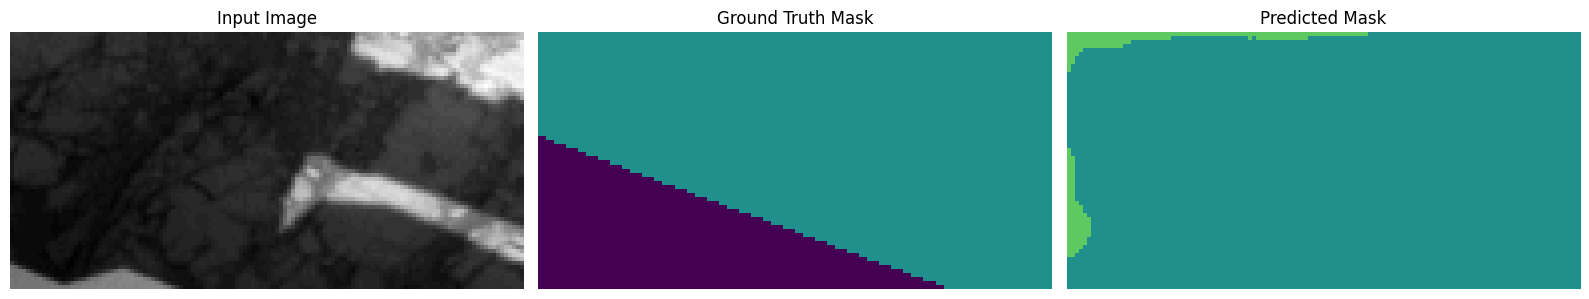

9/9 - 4s - 405ms/step - accuracy: 0.7249 - loss: 4.7309 - mean_iou: 0.8389 - val_accuracy: 0.6804 - val_loss: 4.9618 - val_mean_iou: 0.6613
Epoch 267/1000
9/9 - 3s - 376ms/step - accuracy: 0.7255 - loss: 4.7197 - mean_iou: 0.8405 - val_accuracy: 0.6830 - val_loss: 4.8894 - val_mean_iou: 0.7418
Epoch 268/1000
9/9 - 3s - 377ms/step - accuracy: 0.7265 - loss: 4.7415 - mean_iou: 0.7925 - val_accuracy: 0.7201 - val_loss: 4.7755 - val_mean_iou: 0.7749
Epoch 269/1000
9/9 - 3s - 376ms/step - accuracy: 0.7281 - loss: 4.7351 - mean_iou: 0.8110 - val_accuracy: 0.7180 - val_loss: 4.7516 - val_mean_iou: 0.8351
Epoch 270/1000
9/9 - 3s - 376ms/step - accuracy: 0.7297 - loss: 4.7255 - mean_iou: 0.8383 - val_accuracy: 0.6958 - val_loss: 4.8396 - val_mean_iou: 0.7949
Epoch 271/1000


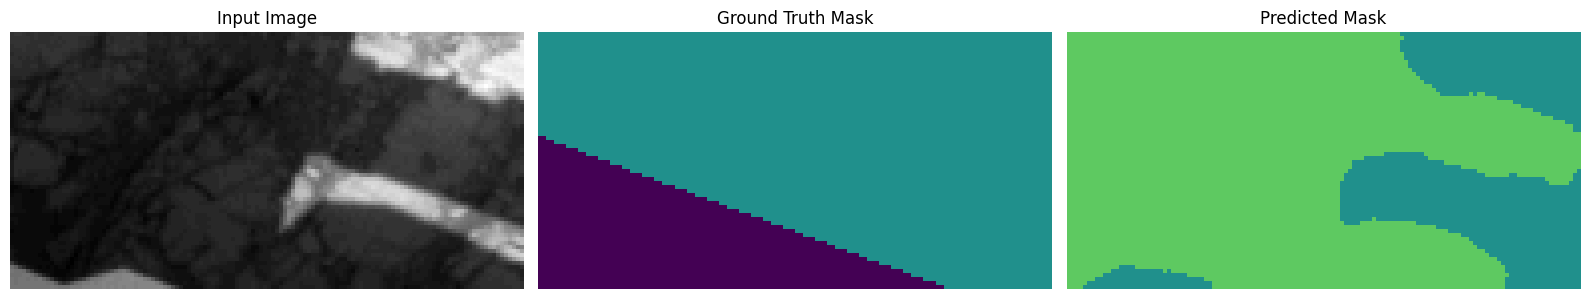

9/9 - 4s - 406ms/step - accuracy: 0.7323 - loss: 4.7125 - mean_iou: 0.8437 - val_accuracy: 0.6398 - val_loss: 5.1488 - val_mean_iou: 0.6895
Epoch 272/1000
9/9 - 3s - 376ms/step - accuracy: 0.7302 - loss: 4.7285 - mean_iou: 0.8156 - val_accuracy: 0.6902 - val_loss: 4.8841 - val_mean_iou: 0.7255
Epoch 273/1000
9/9 - 3s - 376ms/step - accuracy: 0.7292 - loss: 4.7293 - mean_iou: 0.8332 - val_accuracy: 0.7001 - val_loss: 4.8215 - val_mean_iou: 0.7900
Epoch 274/1000
9/9 - 3s - 376ms/step - accuracy: 0.7194 - loss: 4.7514 - mean_iou: 0.8346 - val_accuracy: 0.6883 - val_loss: 4.8782 - val_mean_iou: 0.7784
Epoch 275/1000
9/9 - 3s - 376ms/step - accuracy: 0.7245 - loss: 4.7277 - mean_iou: 0.8335 - val_accuracy: 0.6874 - val_loss: 4.8548 - val_mean_iou: 0.7785
Epoch 276/1000


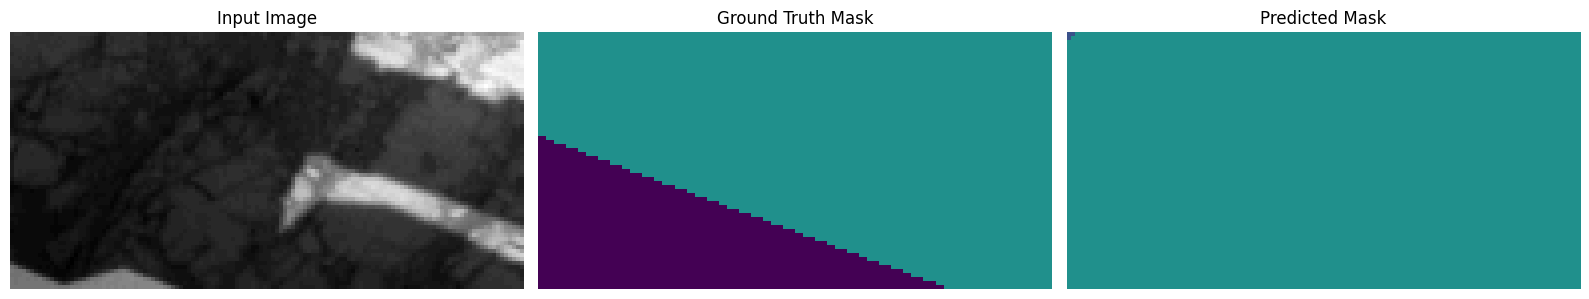

9/9 - 4s - 406ms/step - accuracy: 0.7268 - loss: 4.7403 - mean_iou: 0.8029 - val_accuracy: 0.6958 - val_loss: 4.8338 - val_mean_iou: 0.7297
Epoch 277/1000
9/9 - 3s - 377ms/step - accuracy: 0.7302 - loss: 4.7195 - mean_iou: 0.8290 - val_accuracy: 0.7243 - val_loss: 4.7547 - val_mean_iou: 0.7983
Epoch 278/1000
9/9 - 3s - 378ms/step - accuracy: 0.7297 - loss: 4.7178 - mean_iou: 0.8271 - val_accuracy: 0.7187 - val_loss: 4.7492 - val_mean_iou: 0.8318
Epoch 279/1000
9/9 - 3s - 377ms/step - accuracy: 0.7299 - loss: 4.7271 - mean_iou: 0.8462 - val_accuracy: 0.7233 - val_loss: 4.7380 - val_mean_iou: 0.8472
Epoch 280/1000
9/9 - 3s - 377ms/step - accuracy: 0.7326 - loss: 4.7075 - mean_iou: 0.8545 - val_accuracy: 0.7282 - val_loss: 4.7257 - val_mean_iou: 0.8375
Epoch 281/1000


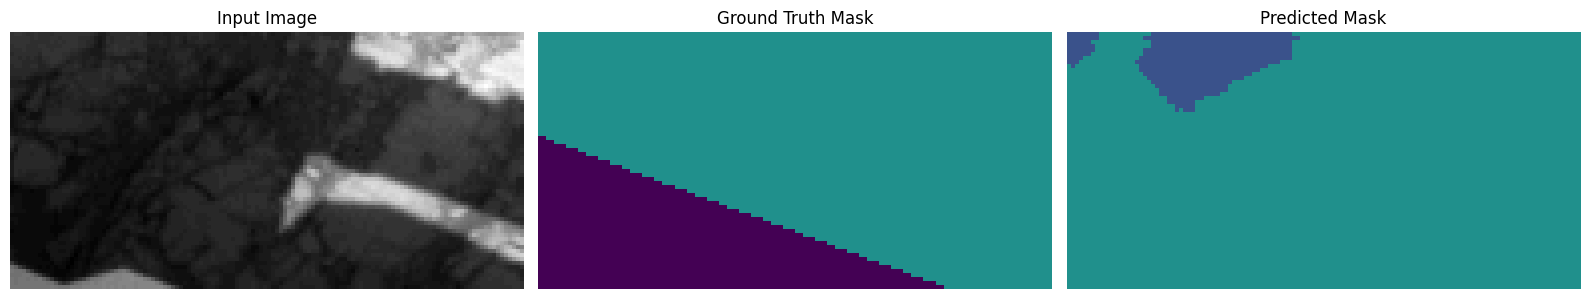

9/9 - 4s - 419ms/step - accuracy: 0.7350 - loss: 4.7095 - mean_iou: 0.8540 - val_accuracy: 0.7259 - val_loss: 4.7235 - val_mean_iou: 0.8492
Final validation Mean Intersection Over Union: 86.3%
UNet_86.3.keras


In [21]:
# Train the model

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=2
).history



# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model
print(model_filename)

In [22]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step
Predictions shape: (10022, 64, 128)


In [23]:
import cv2

def apply_bilateral_filter_batch(images, prob_maps, d=5, sigma_color=75, sigma_space=75):
    """
    Apply bilateral filtering to a batch of images.
    
    Args:
    - images (np.ndarray): Batch of input images (batch_size, height, width).
    - prob_maps (np.ndarray): Batch of softmax probability maps (batch_size, height, width, num_classes).
    - d (int): Diameter of the pixel neighborhood used during filtering.
    - sigma_color (int): Filter sigma in color space (higher means more smoothness).
    - sigma_space (int): Filter sigma in coordinate space (higher means more smoothness).
    
    Returns:
    - np.ndarray: Refined segmentation masks (batch_size, height, width).
    """
    batch_size, h, w, n_classes = prob_maps.shape
    refined_masks = np.zeros((batch_size, h, w), dtype=np.uint8)
    
    for i in range(batch_size):
        prob_map = prob_maps[i]
        for c in range(n_classes):
            # Apply bilateral filter to each class probability map
            smoothed_prob_map = cv2.bilateralFilter(prob_map[..., c], d, sigma_color, sigma_space)
            prob_map[..., c] = smoothed_prob_map
        
        # Choose the class with the maximum probability after filtering
        refined_masks[i] = np.argmax(prob_map, axis=-1)
    
    return refined_masks


def apply_morphological_operations_batch(segmentation_masks, kernel_size=3):
    """
    Apply morphological operations to a batch of segmentation masks.
    
    Args:
    - segmentation_masks (np.ndarray): Batch of predicted segmentation masks (batch_size, height, width).
    - kernel_size (int): Size of the structuring element.
    
    Returns:
    - np.ndarray: Refined segmentation masks (batch_size, height, width).
    """
    batch_size, h, w = segmentation_masks.shape
    refined_masks = np.zeros_like(segmentation_masks)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    
    for i in range(batch_size):
        mask = segmentation_masks[i]
        mask = mask.astype(np.uint8)
        
        # Dilation: Fill small gaps in regions
        dilated = cv2.dilate(mask, kernel, iterations=1)
        
        # Erosion: Remove small noise outside regions
        refined_masks[i] = cv2.erode(dilated, kernel, iterations=1)
    
    return refined_masks

processed_mask = apply_bilateral_filter_batch(X_test, model.predict(X_test))
processed_mask = apply_morphological_operations_batch(processed_mask)

# Create and download the csv submission file
timestep_str = model_filename.replace("post_processed_model_", "").replace(".keras", "")
submission_filename = f"submission_post_processes2.csv"
submission_df = y_to_df(processed_mask)
submission_df.to_csv(submission_filename, index=False)


314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
